#### Imports and Functions

In [1]:
import os
import sys
import configparser
from itertools import combinations
import pandas as pd
import numpy as np
import cv2
import itertools
from itertools import cycle
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,RocCurveDisplay,roc_auc_score,roc_curve,auc,precision_recall_fscore_support,accuracy_score, balanced_accuracy_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader,WeightedRandomSampler
from torch.utils.data import Dataset as BaseDataset

In [2]:
img_mean = IMAGENET_DEFAULT_MEAN
img_std = IMAGENET_DEFAULT_STD

In [3]:
def path_object_to_str(obj):
    if isinstance(obj, Path):
        return str(obj) 

In [4]:
def create_additional_data_frame(folder,num_images=1000):
    files = [item for row in [glob.glob(f'{folder}/{x}/*')[:num_images] for x in ['B','C','V','H','F']] for item in row]
    file_paths = [Path(x).resolve() for x in files]
    file_names = [Path(x).name for x in file_paths]
    classes = [Path(x).parent.name for x in file_paths]

    df_synth = pd.DataFrame(zip(file_paths,file_names,classes),columns=['file_path','file_name','class'])

    df_synth['file_path'] = df_synth['file_path'].apply(lambda x: path_object_to_str(x))
    df_synth['file_name'] = df_synth['file_name'].apply(lambda x: path_object_to_str(x))
    df_synth['split_old'] = 'train'
    df_synth['split'] = 'train'
    df_synth['patient_id'] = 'synth'

    return df_synth


def create_final_dataframe(metadata_file,synth_df):
    df = pd.concat([pd.read_csv(metadata_file),synth_df],ignore_index=True)

    # encode labels
    df['class'] = df['class'].astype('category')
    df['label_encoded'] = df['class'].cat.codes.astype('int64')

    return df

In [5]:
def get_weak_transforms(img_size,img_mean,img_std):
    weak_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return weak_transforms

def get_strong_transforms(img_size,img_mean,img_std):
    strong_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=10, shift_limit=0.1, p=1, border_mode=0),
                        A.OneOf(
                            [
                                A.CLAHE(p=1),
                                A.RandomBrightnessContrast(p=1),
                                A.RandomGamma(p=1),
                            ],
                            p=0.9,
                        ),
                        A.OneOf(
                            [
                                A.Sharpen(p=1),
                                A.Blur(blur_limit=3, p=1),
                                A.MotionBlur(blur_limit=3, p=1),
                            ],
                            p=0.9,
                        ),
                        A.OneOf(
                            [
                                A.RandomBrightnessContrast(p=1),
                                A.HueSaturationValue(p=1),
                            ],
                            p=0.9,
                        ),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return strong_transforms

def get_valid_transforms(img_size,img_mean,img_std):
    valid_transforms = A.Compose([
                        A.Resize(img_size, img_size),
                        A.Normalize(mean=img_mean, std=img_std),
                        ToTensorV2(),
                    ])
    return valid_transforms

In [6]:
class Dataset(BaseDataset):
    """Read images, apply augmentation and preprocessing transformations."""
    
    def __init__(
            self,
            df,
            augmentation=None,
            visualize = False
    ):
        self.df = df.reset_index(drop=True)
        self.ids = self.df.loc[:,'file_name'].values
        self.images_fps = self.df.loc[:,'file_path'].values
        
        self.augmentation = augmentation
        self.visualize = visualize

        self.labels = sorted(self.df['label_encoded'].unique().tolist())
        self.label_names = self.df['class'].cat.categories
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = self.df.loc[i,'label_encoded']
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

        
        # Revert Normalize to visualize the image
            if self.visualize:
                invTrans = A.Normalize(mean=[-x/y for x,y in zip(img_mean,img_std)],
                                       std=[1/x for x in img_std],
                                       max_pixel_value=1.0,
                                       always_apply=True)
                image = image.detach().cpu().numpy().transpose(1,2,0)
                image = invTrans(image=image)['image']
                image = (image*255).astype(np.uint8)
        
        return image, label
        
    def __len__(self):
        return len(self.ids)

In [7]:
class VisionModel:
    def __init__(self,
                 model_architecture,
                 num_classes,
                 dropout_percent=0.5,
                 pretrained=True,
                 device='cuda',
                 checkpoint=False,
                 eval_mode=True):
        self.model_architecture = model_architecture
        self.num_classes = num_classes
        self.dropout_percent = dropout_percent
        self.pretrained = pretrained
        self.device = torch.device(device)
        self.checkpoint=checkpoint
        self.eval_mode = eval_mode
        
        self._load_model()

    def _load_model(self):
        if self.model_architecture == 'convnext_small' or self.model_architecture == 'convnext_tiny':
            self.model = timm.create_model(self.model_architecture, pretrained=self.pretrained, num_classes=self.num_classes,drop_rate=self.dropout_percent)

        if self.model_architecture == 'efficientnet_b0' or self.model_architecture == 'efficientnet_b1':
            self.model = timm.create_model(self.model_architecture, pretrained=self.pretrained, num_classes=self.num_classes)
            num_ftrs = self.model.get_classifier().in_features
            if self.dropout_percent:
                self.model.classifier = nn.Sequential(
                                        nn.Dropout(self.dropout_percent),
                                        nn.Linear(num_ftrs,self.num_classes)
                )
            else:
                self.model.classifier = nn.Linear(num_ftrs, self.num_classes)

        if self.model_architecture == 'resnet50':
            self.model = timm.create_model(self.model_architecture, pretrained=self.pretrained, num_classes=self.num_classes)
            num_ftrs = self.model.get_classifier().in_features
            if self.dropout_percent:
                self.model.fc = nn.Sequential(
                                        nn.Dropout(self.dropout_percent),
                                        nn.Linear(num_ftrs,self.num_classes)
                )
            else:
                self.model.fc = nn.Linear(num_ftrs, self.num_classes)


        if self.checkpoint:
            self.model.load_state_dict(torch.load(self.checkpoint))
        if self.eval_mode:
            self.model = self.model.eval()
        
        self.model = self.model.to(self.device)   
        
    def __call__(self):
        return self.model

In [8]:
class Evaluate:
    def __init__(self,model,dataset,teacher=False):
        self.model = model()
        self.model_class = model
        self.dataset = dataset
        self.teacher = teacher
        self.class_ids = self.dataset.labels
        self.class_names = self.dataset.label_names
        self.label_array = np.array([], dtype='int64')
        self.prediction_array = np.array([], dtype='int64')
        self.softmax_array = np.array([], dtype='float64')
        
        self._perform_cls()
        self._fpr_tpr_calc()



    def _perform_cls(self):
        with torch.no_grad():
            self.model.eval()
            for self.images, self.labels in self.dataset:
                self.images = self.images.to(self.model_class.device).unsqueeze(0)
                #labels = labels.to(device)
                self.cls_outputs = self.model(self.images)
                self.softmax_array = np.append(self.softmax_array,F.softmax(self.cls_outputs,dim=1).detach().cpu().numpy())
                self.softmax_array = np.reshape(self.softmax_array,(-1,self.model.num_classes))
                _, self.predicted = torch.max(self.cls_outputs.data, 1)
                #_,labels = torch.max(labels.data, 0)
                self.label_array = np.append(self.label_array, self.labels)
                self.prediction_array = np.append(self.prediction_array, self.predicted.detach().cpu().numpy())
        
        self.label_array_oh = np.zeros((self.label_array.size, self.label_array.max()+1), dtype=int)
        self.label_array_oh[np.arange(self.label_array.size),self.label_array] = 1
    
    @property
    def print_cls_report(self):
        return classification_report(self.label_array, self.prediction_array, digits=4,zero_division=0)
    
    @property
    def cls_report(self):
        pre_rec_fs_sups = dict()
        
        for label in ['micro','macro','weighted']:
            prfs = precision_recall_fscore_support(
                self.label_array,
                self.prediction_array,
                average=label,
                zero_division=0
            )
            
            
            pre_rec_fs_sups[label] = {'precision' : prfs[0],
                                      'recall' : prfs[1],
                                      'f1-score' : prfs[2],
                                      'support' : prfs[3]
                                     }
        
        per_label_prfs = precision_recall_fscore_support(
            self.label_array,
            self.prediction_array,
            average=None,
            zero_division=0
        )
        
        for class_id in self.class_ids:
                pre_rec_fs_sups[class_id] = {'precision':per_label_prfs[0][class_id],
                                             'recall': per_label_prfs[1][class_id],
                                             'f1-score' : per_label_prfs[2][class_id],
                                             'support' : per_label_prfs[3][class_id]
                                            }
                
        
        acc = accuracy_score(self.label_array,self.prediction_array)
        pre_rec_fs_sups['accuracy'] = acc

        bal_acc = balanced_accuracy_score(self.label_array,self.prediction_array)
        pre_rec_fs_sups['balanced_accuracy'] = bal_acc
        
        return pre_rec_fs_sups
    
    @property
    def auc(self):
        aucs = dict()
        for label in ['micro','macro','weighted']:
            aucs[label] = roc_auc_score(
                self.label_array_oh,
                self.softmax_array,
                multi_class="ovr",
                average=label,
            )
        
        aucs['macro_ovo'] = roc_auc_score(
                self.label_array_oh,
                self.softmax_array,
                multi_class="ovo",
                average='macro',
        )
        
        per_label_auc = roc_auc_score(
            self.label_array_oh,
            self.softmax_array,
            multi_class="ovr",
            average=None,
        )   
        
        for i,value in enumerate(per_label_auc):
            aucs[f'{i}'] = value

        return aucs
    
    def _fpr_tpr_calc(self):
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        # store the fpr, tpr, and roc_auc for all averaging strategies
        self.fpr, self.tpr, self.roc_auc = dict(), dict(), dict()
        # Compute micro-average ROC curve and ROC area for OvR strategy
        self.fpr["micro"], self.tpr["micro"], _ = roc_curve(self.label_array_oh.ravel(), self.softmax_array.ravel(),drop_intermediate=True)
        self.roc_auc["micro"] = auc(self.fpr["micro"], self.tpr["micro"])
        
        interp_tpr = np.interp(fpr_grid,self.fpr['micro'],self.tpr['micro'])
        interp_tpr[0] = 0.0
        self.fpr['micro'] = fpr_grid
        self.tpr['micro'] = interp_tpr
        
        
        self.tresholds = dict()
        for i in range(self.model.num_classes):
            self.fpr[i], self.tpr[i], self.tresholds[i] = roc_curve(self.label_array_oh[:, i], self.softmax_array[:, i])
            self.roc_auc[i] = auc(self.fpr[i], self.tpr[i])

        # Interpolate all ROC curves at these points
        mean_tpr = np.zeros_like(fpr_grid)

        for i in range(self.model.num_classes):
            mean_tpr += np.interp(fpr_grid, self.fpr[i], self.tpr[i])  # linear interpolation

        # Average it and compute AUC
        mean_tpr /= self.model.num_classes

        self.fpr["macro"] = fpr_grid
        self.tpr["macro"] = mean_tpr
        self.roc_auc["macro"] = auc(self.fpr["macro"], self.tpr["macro"])
        
        # Compute macro-average ROC curve and ROC area for OvO strategy
        pair_list = list(combinations(self.class_ids,2))
        
        pair_scores = []
        self.tpr['macro_ovo'] = np.zeros_like(fpr_grid)
        mean_tpr = dict()
        for ix, (label_a, label_b) in enumerate(pair_list):

            a_mask = self.label_array == label_a
            b_mask = self.label_array == label_b
            ab_mask = np.logical_or(a_mask, b_mask)

            a_true = a_mask[ab_mask]
            b_true = b_mask[ab_mask]

            idx_a = np.flatnonzero(np.array(self.class_ids) == label_a)[0]
            idx_b = np.flatnonzero(np.array(self.class_ids) == label_b)[0]

            fpr_a, tpr_a, _ = roc_curve(a_true, self.softmax_array[ab_mask, idx_a])
            fpr_b, tpr_b, _ = roc_curve(b_true, self.softmax_array[ab_mask, idx_b])

            mean_tpr[ix] = np.zeros_like(fpr_grid)
            mean_tpr[ix] += np.interp(fpr_grid, fpr_a, tpr_a)
            mean_tpr[ix] += np.interp(fpr_grid, fpr_b, tpr_b)
            mean_tpr[ix] /= 2
            mean_score = auc(fpr_grid, mean_tpr[ix])
            pair_scores.append(mean_score)
            self.tpr['macro_ovo'] += mean_tpr[ix]
            
        self.tpr['macro_ovo'] /= sum(1 for pair in enumerate(pair_list))
        self.fpr['macro_ovo'] = fpr_grid
        self.roc_auc['macro_ovo'] = np.average(pair_scores)
    
    def roc(self,contents=[]):
        assert contents is not None
        fig, ax = plt.subplots(figsize=(6, 6))
        
        colors = cycle(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"])
        
        for class_id, color in zip([x for x in contents if x not in ['micro','macro']], colors):
            plt.plot(
                self.fpr[class_id],
                self.tpr[class_id],
                label=f"ROC curve for {class_id} (AUC = {self.roc_auc[class_id]:.2f})",
                color=color     
            )
        
        if 'micro' in contents:
            plt.plot(
                self.fpr["micro"],
                self.tpr["micro"],
                label=f"micro-average ROC curve (AUC = {self.roc_auc['micro']:.2f})",
                color="deeppink",
                linestyle=":",
                linewidth=4,
            )
        
        if 'macro' in contents:
            plt.plot(
                self.fpr["macro"],
                self.tpr["macro"],
                label=f"macro-average ROC curve (AUC = {self.roc_auc['macro']:.2f})",
                color="navy",
                linestyle=":",
                linewidth=4,
            )
            
        plt.plot([0, 1], [0, 1], "k--")
        plt.axis("square")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("Receiver Operating Characteristic")
        plt.legend()
        return fig,ax

In [9]:
def cv_cls_report(ev_models,labels,folds,digits=4):
    cv_cls_report = {}
    labels.extend(['micro','macro', 'weighted'])
    folds = range(folds)
    accs = []
    bal_accs = []
    for fold in folds:
        accs.append(ev_models[fold].cls_report['accuracy'])
        bal_accs.append(ev_models[fold].cls_report['balanced_accuracy'])

    cv_cls_report['accuracy'] = [round(np.mean(accs),digits),round(np.std(accs),digits)]
    cv_cls_report['balanced_accuracy'] = [round(np.mean(bal_accs),digits),round(np.std(bal_accs),digits)]

    avg_prec = {}
    avg_rec = {}
    avg_f1 = {}
    for label in labels:
        precs = []
        recs = []
        f1s = []
        sups = []
        for fold in folds:
            precs.append(ev_models[fold].cls_report[label]['precision'])
            recs.append(ev_models[fold].cls_report[label]['recall'])
            f1s.append(ev_models[fold].cls_report[label]['f1-score'])
            
        avg_prec[label] = [round(np.mean(precs),digits),round(np.std(precs),digits)]
        avg_rec[label] = [round(np.mean(recs),digits),round(np.std(recs),digits)]
        avg_f1[label] = [round(np.mean(f1s),digits),round(np.std(f1s),digits)]

        metric_dict = {}
        metric_dict['precision'] = avg_prec[label]
        metric_dict['recall'] = avg_rec[label]
        metric_dict['f1-score'] = avg_f1[label]
        cv_cls_report[label] = metric_dict
        
    return cv_cls_report

In [10]:
def cv_auc(ev_models,contents,n_folds,digits=4):
    avg_auc = {}
    for class_id in contents:
        values = []
        for fold in range(n_folds):
            if class_id == 'weighted':
                values.append(ev_models[fold].auc[class_id])
            else:
                values.append(ev_models[fold].roc_auc[class_id])
        avg_auc[class_id] = [round(np.mean(values),digits),round(np.std(values),digits)]
    return avg_auc

In [11]:
def cv_roc(ev_models,contents,folds,ax,title='Receiver Operating Characteristic',save=None):
    avg_tpr = {}
    avg_fpr = {}
    avg_auc = {}
    std_auc = {}

    colors = cycle(["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown"])

    for class_id, color in zip([x for x in contents if x not in ['micro','macro','macro_ovo']], colors):
        fpr_grid = np.linspace(0.0, 1.0, 1000)
        mean_tpr = np.zeros_like(fpr_grid)
        aucs = []
        for fold in range(folds):
            mean_tpr += np.interp(fpr_grid, ev_models[fold].fpr[class_id], ev_models[fold].tpr[class_id])
            aucs.append(ev_models[fold].roc_auc[class_id])

        avg_tpr[class_id] = mean_tpr / folds
        avg_fpr[class_id] = fpr_grid
        avg_auc[class_id] = np.mean(aucs)
        std_auc[class_id] = np.std(aucs)
        
        ax.plot(
            avg_fpr[class_id],
            avg_tpr[class_id],
            label=f"Severity {class_id} (AUC = {avg_auc[class_id]:.2f} $\pm$ {std_auc[class_id]:.2f})" if class_id != 0 else f"Healthy (AUC = {avg_auc[class_id]:.2f} $\pm$ {std_auc[class_id]:.2f})",
            color=color     
        )
        
    if 'micro' in contents:
        tprs = []
        fprs = []
        aucs = []
        for fold in range(folds):
            tprs.append(ev_models[fold].tpr['micro'])
            fprs.append(ev_models[fold].fpr['micro'])
            aucs.append(ev_models[fold].roc_auc['micro'])
        avg_fpr["micro"] = np.mean(fprs,axis=0)
        avg_tpr["micro"] = np.mean(tprs,axis=0)
        avg_auc["micro"] = np.mean(aucs)
        std_auc["micro"] = np.std(aucs)
         
        ax.plot(
            avg_fpr["micro"],
            avg_tpr["micro"],
            label=f"micro-average (AUC = {avg_auc['micro']:.2f} $\pm$ {std_auc['micro']:.2f})",
            color="deeppink",
            linestyle=":",
            linewidth=4,
        )
        
    if 'macro' in contents:
        tprs = []
        fprs = []
        aucs = []
        for fold in range(folds):
            tprs.append(ev_models[fold].tpr['macro'])
            fprs.append(ev_models[fold].fpr['macro'])
            aucs.append(ev_models[fold].roc_auc['macro'])
        avg_fpr["macro"] = np.mean(fprs,axis=0)
        avg_tpr["macro"] = np.mean(tprs,axis=0)
        avg_auc["macro"] = np.mean(aucs)
        std_auc["macro"] = np.std(aucs)
            
        ax.plot(
            avg_fpr["macro"],
            avg_tpr["macro"],
            label=f"macro-average (AUC = {avg_auc['macro']:.2f} $\pm$ {std_auc['macro']:.2f})",
            color="navy",
            linestyle=":",
            linewidth=4,
        )
        
    if 'macro_ovo' in contents:
        tprs = []
        fprs = []
        aucs = []
        for fold in range(folds):
            tprs.append(ev_models[fold].tpr['macro_ovo'])
            fprs.append(ev_models[fold].fpr['macro_ovo'])
            aucs.append(ev_models[fold].roc_auc['macro_ovo'])
        avg_fpr["macro_ovo"] = np.mean(fprs,axis=0)
        avg_tpr["macro_ovo"] = np.mean(tprs,axis=0)
        avg_auc["macro_ovo"] = np.mean(aucs)
        std_auc["macro_ovo"] = np.std(aucs)
            
        ax.plot(
            avg_fpr["macro"],
            avg_tpr["macro"],
            label=f"OvO macro-average (AUC = {avg_auc['macro_ovo']:.2f} $\pm$ {std_auc['macro_ovo']:.2f})",
            color="cyan",
            linestyle=":",
            linewidth=4,
        )

    ax.plot([0, 1], [0, 1], "k--")
    ax.axis("square")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title(title)
    ax.legend()

In [12]:
def load_experiment(name):
    config_file = f'configs/{name}_config.txt'
    config = configparser.ConfigParser()
    config.read(config_file)

    model_dir = config['settings']['model_dir']
    repeated_runs = int(config['settings']['repeated_runs'])
    additional_data_folder = config['settings']['additional_data_folder']
    metadata_file = config['settings']['metadata_file']
    num_images = eval(config['settings']['num_synth_images'])
    resolution = int(config['model']['resolution'])

    if 'model' in config:
        dropout_percent = float(config['model']['dropout_percent'])
        model_architecture = config['model']['model_architecture']
    else:
        dropout_percent = (float(config['teacher']['dropout_percent']),float(config['student']['dropout_percent']))
        model_architecture = (config['teacher']['model_architecture'],config['student']['model_architecture'])

    return model_dir, model_architecture, dropout_percent, repeated_runs, resolution, additional_data_folder, metadata_file

In [13]:
def plot_loss_curve(experiment_name,model_architecture,plot_type,repeated_runs,additional_images,ax,student_losses=[]):

    logs = pd.read_csv(f'logs/{experiment_name}_{model_architecture}_{additional_images}_metrics.csv')

    train_values = []
    valid_values = []
    for fold in range(repeated_runs):
        train_values.append(logs[f'fold{fold}_train_{plot_type}'].values)
        valid_values.append(logs[f'fold{fold}_val_{plot_type}'].values)
    
    mean_train_values = np.mean(train_values,axis=0)
    mean_valid_values = np.mean(valid_values,axis=0)

    
    for values in train_values:
        ax.plot(range(len(logs)),values,color="tab:blue",linewidth=1,alpha=0.3)

        
    label = f'Train {plot_type}'
        
    ax.plot(range(len(logs)),mean_train_values,label=label,color="tab:blue",linewidth=3)

    for values in valid_values:
        ax.plot(range(len(logs)),values,color="tab:orange",linewidth=1,alpha=0.3)
        
    # Plot mean
    ax.plot(range(len(logs)),mean_valid_values,label=f'Valid {plot_type}',color="tab:orange",linewidth=3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel('Accuracy' if plot_type=='acc' else 'Loss')
    ax.legend()

In [14]:
def get_metrics(ev_models,repeated_runs):
    metrics_list = []
    rep = cv_cls_report(ev_models,[0,1,2,3,4],repeated_runs)
    for label in [0,1,2,3,4]:
        for metric in ['precision','recall','f1-score']:
            for value in [0,1]:
                metrics_list.append(rep[label][metric][value])

    acc_mean = rep['accuracy'][0]
    acc_std = rep['accuracy'][1]
    bal_acc_mean = rep['balanced_accuracy'][0]
    bal_acc_std = rep['balanced_accuracy'][1]

    return metrics_list,acc_mean,acc_std,bal_acc_mean,bal_acc_std

In [15]:
def calc_save_metrics(experiment_names,additional_images,csv_name):
    vm_list = []
    ev_list = []
    metrics_dict_all = {}
    acc_mean_all = []
    acc_std_all = []
    bal_acc_mean_all = []
    bal_acc_std_all = []

    for experiment in experiment_names:
        model_dir, model_architecture, dropout_percent, repeated_runs, resolution, additional_data_folder, metadata_file = load_experiment(experiment)

        vision_models = {}
        ev_models = {}

        df_synth = create_additional_data_frame(additional_data_folder,num_images=additional_images)
        df = create_final_dataframe(metadata_file,df_synth)

        valid_dataset = Dataset(
            df[df['split']=='valid'],
            augmentation=get_valid_transforms(resolution,img_mean,img_std), 
        )

        for fold in range(repeated_runs):
            vision_models[fold] = VisionModel(model_architecture,
                                        num_classes=5,
                                        dropout_percent=dropout_percent,
                                        checkpoint=f'./{model_dir}/{experiment}_{model_architecture}_images_{additional_images}_run_{fold}.pth')
        
            ev_models[fold] = Evaluate(vision_models[fold],valid_dataset)

        vm_list.append(vision_models)
        ev_list.append(ev_models)

        metrics_list, acc_mean, acc_std, bal_acc_mean, bal_acc_std = get_metrics(ev_models,repeated_runs)
        metrics_dict_all[experiment] = metrics_list
        acc_mean_all.append(acc_mean)
        acc_std_all.append(acc_std)
        bal_acc_mean_all.append(bal_acc_mean)
        bal_acc_std_all.append(bal_acc_std)

        fig, axs = plt.subplots(1,2,figsize=(10,4),dpi=150)
        plot_loss_curve(experiment,model_architecture,plot_type='acc',repeated_runs=repeated_runs,additional_images=additional_images,ax=axs[0])
        plot_loss_curve(experiment,model_architecture,plot_type='loss',repeated_runs=repeated_runs,additional_images=additional_images,ax=axs[1])
        plt.savefig(f'export/{experiment}_images_{additional_images}_acc_loss_curve.png')
        plt.close()
        

    df = pd.DataFrame.from_dict(metrics_dict_all,orient='index')
    df.columns = pd.MultiIndex.from_product([[0,1,2,3,4],['Prec','Rec','F1'],['mean','std']])
    df['acc_mean'] = acc_mean_all
    df['acc_std'] = acc_std_all
    df['bal_acc_mean'] = bal_acc_mean_all
    df['bal_acc_std'] = bal_acc_std_all

    df.to_csv(f'export/clf_metrics/{csv_name}')

In [16]:
def print_metric_for_latex(df,model_index,metric_index):
    print(df.transpose().iloc[0,model_index])
    f = ''
    for i,value in enumerate(df.transpose().iloc[metric_index,model_index].values):
        if (i % 2) == 0:
            f = f+str(value)+' $\\pm$ '
        else:
            f = f+str(value)+' & '
    print(f)

In [17]:
def print_eval_table_latex(df,methods,models,metrics):
    text = ''
    for i,method in enumerate(methods):
        text = text + method + ' & '
        for k,(model,metric) in enumerate(itertools.product(models,metrics)):
            if len(metrics) == 2:
                if (k % 2) == 0:
                    text = text + str(round(df.loc[df['method']==method,f'{model}_{metric}'].item()*100,2))+' $\\pm$ '
                else:
                    text = text + str(round(df.loc[df['method']==method,f'{model}_{metric}'].item()*100,2))+' & '
            else:
                text = text + str(round(df.loc[df['method']==method,f'{model}_{metric}'].item()*100,2))+' & '
        text = text[:-2] + '\\\\' +'\n'
    print(text)

In [18]:
def create_pivot_table(df,metric=['acc_mean','acc_std']):
    df.loc[df['model'].str.contains('gan'),'method'] = 'gan'
    df.loc[df['model'].str.contains('sd_finetuning'),'method'] = 'finetuning'
    df.loc[df['model'].str.contains('sd_dreambooth'),'method'] = 'dreambooth'
    df.loc[df['model'].str.contains('unconditional'),'method'] = 'unconditional'
    df.loc[df['model'].str.contains('sd_lora_1e5_scale1'),'method'] = 'lora'

    df.loc[df['model'].str.contains('ConvNeXt_small'),'model'] = 'ConvNeXt_small'
    df.loc[df['model'].str.contains('ConvNeXt_tiny'),'model'] = 'ConvNeXt_tiny'
    df.loc[df['model'].str.contains('EB0'),'model'] = 'EB0'
    df.loc[df['model'].str.contains('EB1'),'model'] = 'EB1'
    df.loc[df['model'].str.contains('ResNet50'),'model'] = 'ResNet50'

    df_pivot = df[['model','method']+metric].pivot(columns='model',index='method')
    df_pivot.columns = df[['model','method']+metric].pivot(columns='model',index='method').columns.swaplevel()

    df_pivot.sort_index(axis=1, level=0, inplace=True)
    df_pivot.columns = ['_'.join(col) for col in df_pivot.columns.values]
    df_pivot.reset_index(inplace=True)

    return df_pivot

In [19]:
def print_model_means_latex(df,metric='acc'):
    mean_list = [round(x*100,2) for x in df[[f'ResNet50_{metric}_mean',f'EB0_{metric}_mean',f'EB1_{metric}_mean',f'ConvNeXt_tiny_{metric}_mean',f'ConvNeXt_small_{metric}_mean']].mean().to_list()]
    total_mean = round(np.mean(df[[f'ResNet50_{metric}_mean',f'EB0_{metric}_mean',f'EB1_{metric}_mean',f'ConvNeXt_tiny_{metric}_mean',f'ConvNeXt_small_{metric}_mean']].values)*100,2)

    text = ''
    for value in mean_list+[total_mean]:
        text = text + str(value) + ' & '

    text = text[:-2] + '\\\\' +'\n'

    print(text)

In [20]:
def print_plain_values_to_latex(df,rounding=False,mean_std=False):
    text = ''
    
    if mean_std:
        for row in df.index:
            text = text + str(row) + ' & '

            for k,column in enumerate(df.columns):
                if (k % 2) == 0:
                    if rounding:
                        text = text + str(round(df.loc[row,column]*100,2)) +' $\\pm$ '
                    else:
                        text = text + str(df.loc[row,column]) + ' $\\pm$ '
                else:
                    if rounding:
                        text = text + str(round(df.loc[row,column]*100,2)) + ' & '
                    else:
                        text = text + str(df.loc[row,column]) + ' & '

            text = text[:-2] + '\\\\' +'\n'
    else:
        for row in df.index:
            text = text + str(row) + ' & '

            for column in df.columns:
                if rounding:
                    text = text + str(round(df.loc[row,column]*100,2)) + ' & '
                else:
                    text = text + str(df.loc[row,column]) + ' & '

            text = text[:-2] + '\\\\' +'\n'

    print(text)

In [21]:
models = ['ResNet50','EB0','EB1','ConvNeXt_tiny','ConvNeXt_small']
metrics = ['acc_mean','acc_std']
methods = ['dreambooth','finetuning','gan','lora','unconditional']

In [22]:
baseline_accs = {'ConvNeXt_small_acc_mean' : 0.7853,
                 'ConvNeXt_tiny_acc_mean' : 0.7825, 
                 'EB0_acc_mean' : 0.7871,
                 'EB1_acc_mean' : 0.7760, 
                 'ResNet50_acc_mean' : 0.7825}

In [23]:
baseline_bal_accs = {'ConvNeXt_small_bal_acc_mean' : 0.5478,
                 'ConvNeXt_tiny_bal_acc_mean' : 0.5635, 
                 'EB0_bal_acc_mean' : 0.5400,
                 'EB1_bal_acc_mean' : 0.5522, 
                 'ResNet50_bal_acc_mean' : 0.5222}

In [24]:
label_mapping = {0 : 'B',
                 1 : 'C',
                 2 : 'H',
                 3 : 'F',
                 4 : 'V'}

#### Baseline

In [25]:
df = pd.read_csv('../KD_Paper/Revision/export/model_metrics_do_balacc.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_Baseline,0.326,0.0498,0.3474,0.0976,0.3307,0.0579,0.8292,0.0573,0.7478,...,0.1329,0.1097,0.1,0.0848,0.1136,0.0949,0.7853,0.0037,0.5478,0.0091
3,ConvNeXt_tiny_Baseline,0.3534,0.0405,0.3579,0.1021,0.3515,0.0707,0.7218,0.0693,0.8,...,0.3369,0.0778,0.3125,0.1854,0.2903,0.0981,0.7825,0.0147,0.5635,0.0236
4,EB0_Baseline,0.2952,0.1805,0.1474,0.1021,0.1959,0.1295,0.6999,0.0435,0.7739,...,0.1152,0.1029,0.1,0.0935,0.1069,0.0977,0.7871,0.0122,0.5400,0.0246
5,EB1_Baseline,0.2273,0.1211,0.1158,0.0698,0.1526,0.0878,0.665,0.0782,0.7652,...,0.3607,0.0746,0.425,0.1075,0.3842,0.0738,0.7760,0.0119,0.5522,0.0294
6,ResNet50_Baseline,0.3107,0.2539,0.0947,0.0614,0.1428,0.095,0.7188,0.1223,0.7043,...,0.0545,0.1091,0.075,0.15,0.0632,0.1263,0.7825,0.0114,0.5222,0.0136


##### Accuracy

In [26]:
df_pivot = create_pivot_table(df,metric=['acc_mean','acc_std'])

In [27]:
df_pivot['method'] = 'Baseline'

In [28]:
df_pivot = df_pivot[['method','ResNet50_acc_mean','ResNet50_acc_std','EB0_acc_mean',
                     'EB0_acc_std','EB1_acc_mean','EB1_acc_std','ConvNeXt_tiny_acc_mean',
                     'ConvNeXt_tiny_acc_std','ConvNeXt_small_acc_mean','ConvNeXt_small_acc_std']]

In [29]:
print_plain_values_to_latex(df_pivot.set_index('method'),rounding=True,mean_std=True)

Baseline & 78.25 $\pm$ 1.14 & 78.71 $\pm$ 1.22 & 77.6 $\pm$ 1.19 & 78.25 $\pm$ 1.47 & 78.53 $\pm$ 0.37 \\



##### Balanced Accuracy

In [30]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [31]:
df_pivot['method'] = 'Baseline'

In [32]:
df_pivot = df_pivot[['method','ResNet50_bal_acc_mean','ResNet50_bal_acc_std','EB0_bal_acc_mean',
                     'EB0_bal_acc_std','EB1_bal_acc_mean','EB1_bal_acc_std','ConvNeXt_tiny_bal_acc_mean',
                     'ConvNeXt_tiny_bal_acc_std','ConvNeXt_small_bal_acc_mean','ConvNeXt_small_bal_acc_std']]

In [33]:
print_plain_values_to_latex(df_pivot.set_index('method'),rounding=True,mean_std=True)

Baseline & 52.22 $\pm$ 1.36 & 54.0 $\pm$ 2.46 & 55.22 $\pm$ 2.94 & 56.35 $\pm$ 2.36 & 54.78 $\pm$ 0.91 \\



#### +100

In [34]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan',
#                    'ConvNeXt_small_sd_finetuning','ConvNeXt_tiny_sd_finetuning','EB0_sd_finetuning','EB1_sd_finetuning','ResNet50_sd_finetuning',
#                    'ConvNeXt_small_sd_dreambooth','ConvNeXt_tiny_sd_dreambooth','EB0_sd_dreambooth','EB1_sd_dreambooth','ResNet50_sd_dreambooth',
#                    'ConvNeXt_small_unconditional','ConvNeXt_tiny_unconditional','EB0_unconditional','EB1_unconditional','ResNet50_unconditional',
#                    'ConvNeXt_small_sd_lora_1e5_scale1','ConvNeXt_tiny_sd_lora_1e5_scale1','EB0_sd_lora_1e5_scale1','EB1_sd_lora_1e5_scale1','ResNet50_sd_lora_1e5_scale1']
# calc_save_metrics(experiment_names,additional_images=100,csv_name='model_metrics_100.csv')

In [35]:
df = pd.read_csv('export/clf_metrics/model_metrics_100.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.3228,0.0242,0.2737,0.0774,0.289,0.0338,0.8708,0.1249,0.6435,...,0.1895,0.0772,0.125,0.0559,0.145,0.0636,0.7696,0.0200,0.5151,0.0336
3,ConvNeXt_tiny_gan,0.3699,0.0445,0.3895,0.1134,0.3758,0.0777,0.7699,0.0934,0.8087,...,0.2467,0.2561,0.075,0.0612,0.1088,0.0915,0.7899,0.0159,0.5558,0.0283
4,EB0_gan,0.3967,0.1431,0.1263,0.0537,0.1838,0.0622,0.687,0.0648,0.8,...,0.1646,0.1017,0.1625,0.151,0.1486,0.1134,0.7797,0.0168,0.5332,0.0183
5,EB1_gan,0.2,0.1944,0.1158,0.1389,0.1437,0.1607,0.7072,0.0626,0.7913,...,0.251,0.0576,0.1625,0.0848,0.192,0.0831,0.7843,0.0128,0.5368,0.0243
6,ResNet50_gan,0.4168,0.0676,0.2105,0.0471,0.2714,0.0332,0.7719,0.0318,0.7565,...,0.2286,0.0795,0.275,0.0637,0.243,0.0556,0.7714,0.0219,0.5316,0.0363
7,ConvNeXt_small_sd_finetuning,0.2955,0.151,0.3474,0.2297,0.3071,0.1677,0.7164,0.0696,0.7478,...,0.5112,0.1291,0.2375,0.0468,0.3164,0.0465,0.8037,0.0107,0.5899,0.0263
8,ConvNeXt_tiny_sd_finetuning,0.279,0.0235,0.2526,0.1073,0.2548,0.0701,0.788,0.0924,0.6609,...,0.2976,0.0613,0.2875,0.1225,0.2726,0.0891,0.7742,0.0157,0.5401,0.0181
9,EB0_sd_finetuning,0.4814,0.1371,0.1684,0.0614,0.2448,0.0747,0.7602,0.1138,0.7565,...,0.2639,0.089,0.325,0.1447,0.2864,0.1164,0.7705,0.0176,0.5340,0.0337
10,EB1_sd_finetuning,0.3622,0.0472,0.2737,0.0774,0.3062,0.0639,0.7943,0.0429,0.7565,...,0.3082,0.0612,0.325,0.025,0.3135,0.0343,0.7733,0.0147,0.5486,0.0170
11,ResNet50_sd_finetuning,0.2808,0.1624,0.1474,0.0906,0.1917,0.1131,0.7385,0.1478,0.6957,...,0.2931,0.0936,0.3375,0.0848,0.3101,0.0841,0.7622,0.0188,0.5176,0.0339


##### Accuracy

In [36]:
df_pivot = create_pivot_table(df)

In [37]:
print_eval_table_latex(df_pivot,methods,models,['acc_mean','acc_std'])

dreambooth & 75.94 $\pm$ 1.44 & 79.54 $\pm$ 0.75 & 79.35 $\pm$ 1.5 & 78.06 $\pm$ 1.39 & 79.26 $\pm$ 1.77 \\
finetuning & 76.22 $\pm$ 1.88 & 77.05 $\pm$ 1.76 & 77.33 $\pm$ 1.47 & 77.42 $\pm$ 1.57 & 80.37 $\pm$ 1.07 \\
gan & 77.14 $\pm$ 2.19 & 77.97 $\pm$ 1.68 & 78.43 $\pm$ 1.28 & 78.99 $\pm$ 1.59 & 76.96 $\pm$ 2.0 \\
lora & 74.84 $\pm$ 1.56 & 76.13 $\pm$ 0.98 & 77.6 $\pm$ 0.63 & 78.43 $\pm$ 2.19 & 76.77 $\pm$ 1.71 \\
unconditional & 75.67 $\pm$ 1.18 & 75.67 $\pm$ 0.84 & 78.53 $\pm$ 1.35 & 77.88 $\pm$ 1.3 & 79.45 $\pm$ 1.61 \\



In [38]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [39]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [40]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 100

In [41]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,dreambooth,-0.0231,0.0083,0.0175,-0.0019,0.0073,0.00162,100
1,finetuning,-0.0203,-0.0166,-0.0027,-0.0083,0.0184,-0.00590,100
2,gan,-0.0111,-0.0074,0.0083,0.0074,-0.0157,-0.00370,100
3,lora,-0.0341,-0.0258,0.0000,0.0018,-0.0176,-0.01514,100
4,unconditional,-0.0258,-0.0304,0.0093,-0.0037,0.0092,-0.00828,100


In [42]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

dreambooth & -2.31 & 0.83 & 1.75 & -0.19 & 0.73 & 0.16 \\
finetuning & -2.03 & -1.66 & -0.27 & -0.83 & 1.84 & -0.59 \\
gan & -1.11 & -0.74 & 0.83 & 0.74 & -1.57 & -0.37 \\
lora & -3.41 & -2.58 & 0.0 & 0.18 & -1.76 & -1.51 \\
unconditional & -2.58 & -3.04 & 0.93 & -0.37 & 0.92 & -0.83 \\



In [43]:
print_model_means_latex(df_pivot_delta)

-2.29 & -1.44 & 0.65 & -0.09 & 0.03 & -0.63 \\



In [44]:
df_total_pivot = df_pivot_delta.copy()

##### Balanced Accuracy

In [45]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [46]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,dreambooth,0.5550,0.0355,0.5556,0.0287,0.5602,0.0162,0.5720,0.0316,0.4806,0.0261
1,finetuning,0.5899,0.0263,0.5401,0.0181,0.5340,0.0337,0.5486,0.0170,0.5176,0.0339
2,gan,0.5151,0.0336,0.5558,0.0283,0.5332,0.0183,0.5368,0.0243,0.5316,0.0363
3,lora,0.5363,0.0274,0.5663,0.0342,0.5067,0.0172,0.5532,0.0191,0.4472,0.0342
4,unconditional,0.5873,0.0236,0.5423,0.0184,0.5145,0.0177,0.5481,0.0195,0.5120,0.0251


In [47]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

dreambooth & 48.06 $\pm$ 2.61 & 56.02 $\pm$ 1.62 & 57.2 $\pm$ 3.16 & 55.56 $\pm$ 2.87 & 55.5 $\pm$ 3.55 \\
finetuning & 51.76 $\pm$ 3.39 & 53.4 $\pm$ 3.37 & 54.86 $\pm$ 1.7 & 54.01 $\pm$ 1.81 & 58.99 $\pm$ 2.63 \\
gan & 53.16 $\pm$ 3.63 & 53.32 $\pm$ 1.83 & 53.68 $\pm$ 2.43 & 55.58 $\pm$ 2.83 & 51.51 $\pm$ 3.36 \\
lora & 44.72 $\pm$ 3.42 & 50.67 $\pm$ 1.72 & 55.32 $\pm$ 1.91 & 56.63 $\pm$ 3.42 & 53.63 $\pm$ 2.74 \\
unconditional & 51.2 $\pm$ 2.51 & 51.45 $\pm$ 1.77 & 54.81 $\pm$ 1.95 & 54.23 $\pm$ 1.84 & 58.73 $\pm$ 2.36 \\



In [48]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [49]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [50]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 100

In [51]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,dreambooth,-0.0416,0.0202,0.0198,-0.0079,0.0072,-0.00046,100
1,finetuning,-0.0046,-0.0060,-0.0036,-0.0234,0.0421,0.00090,100
2,gan,0.0094,-0.0068,-0.0154,-0.0077,-0.0327,-0.01064,100
3,lora,-0.0750,-0.0333,0.0010,0.0028,-0.0115,-0.02320,100
4,unconditional,-0.0102,-0.0255,-0.0041,-0.0212,0.0395,-0.00430,100


In [52]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

dreambooth & -4.16 & 2.02 & 1.98 & -0.79 & 0.72 & -0.05 \\
finetuning & -0.46 & -0.6 & -0.36 & -2.34 & 4.21 & 0.09 \\
gan & 0.94 & -0.68 & -1.54 & -0.77 & -3.27 & -1.06 \\
lora & -7.5 & -3.33 & 0.1 & 0.28 & -1.15 & -2.32 \\
unconditional & -1.02 & -2.55 & -0.41 & -2.12 & 3.95 & -0.43 \\



In [53]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

-2.44 & -1.03 & -0.05 & -1.15 & 0.89 & -0.75 \\



In [54]:
df_total_pivot_balacc = df_pivot_delta.copy()

#### +250

In [55]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan',
#                   'ConvNeXt_small_sd_finetuning','ConvNeXt_tiny_sd_finetuning','EB0_sd_finetuning','EB1_sd_finetuning','ResNet50_sd_finetuning',
#                   'ConvNeXt_small_sd_dreambooth','ConvNeXt_tiny_sd_dreambooth','EB0_sd_dreambooth','EB1_sd_dreambooth','ResNet50_sd_dreambooth',
#                   'ConvNeXt_small_unconditional','ConvNeXt_tiny_unconditional','EB0_unconditional','EB1_unconditional','ResNet50_unconditional',
#                   'ConvNeXt_small_sd_lora_1e5_scale1','ConvNeXt_tiny_sd_lora_1e5_scale1','EB0_sd_lora_1e5_scale1','EB1_sd_lora_1e5_scale1','ResNet50_sd_lora_1e5_scale1']
# calc_save_metrics(experiment_names,additional_images=250,csv_name='model_metrics_250.csv')

In [56]:
df = pd.read_csv('export/clf_metrics/model_metrics_250.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.325,0.0578,0.2947,0.1031,0.3023,0.0673,0.7829,0.0791,0.8,...,0.1912,0.1119,0.15,0.0848,0.1663,0.0941,0.7816,0.0205,0.5453,0.0353
3,ConvNeXt_tiny_gan,0.3475,0.0468,0.3263,0.0394,0.3352,0.0374,0.8669,0.077,0.7217,...,0.2416,0.0297,0.25,0.1531,0.2248,0.0923,0.7677,0.0159,0.5326,0.0243
4,EB0_gan,0.35,0.2261,0.1368,0.0788,0.1842,0.0994,0.7253,0.0506,0.7217,...,0.1966,0.0423,0.325,0.1551,0.2379,0.0725,0.7465,0.0134,0.4945,0.0112
5,EB1_gan,0.3657,0.0936,0.2316,0.1084,0.2785,0.1127,0.7492,0.0309,0.7478,...,0.1888,0.0517,0.175,0.0729,0.1795,0.0644,0.7687,0.0132,0.5218,0.0331
6,ResNet50_gan,0.2883,0.1233,0.1263,0.0714,0.174,0.0917,0.7325,0.0514,0.7478,...,0.234,0.0578,0.3125,0.1311,0.2571,0.0781,0.7631,0.0245,0.5164,0.0298
7,ConvNeXt_small_sd_finetuning,0.3256,0.0796,0.3158,0.1761,0.3102,0.1312,0.7732,0.0739,0.7217,...,0.4607,0.0813,0.25,0.125,0.3028,0.0718,0.7954,0.0156,0.5743,0.0314
8,ConvNeXt_tiny_sd_finetuning,0.1995,0.1031,0.2421,0.1511,0.2154,0.1207,0.873,0.0605,0.5826,...,0.3437,0.0471,0.1875,0.0884,0.2324,0.0864,0.7668,0.0075,0.5140,0.0293
9,EB0_sd_finetuning,0.4079,0.0914,0.2421,0.0714,0.2921,0.0443,0.7763,0.1092,0.6783,...,0.1933,0.1181,0.1625,0.0935,0.1719,0.0976,0.7696,0.0124,0.5188,0.0194
10,EB1_sd_finetuning,0.3509,0.1794,0.2211,0.1172,0.2698,0.1397,0.6829,0.0641,0.7739,...,0.3044,0.149,0.2,0.1,0.2384,0.1169,0.7806,0.0164,0.5423,0.0330
11,ResNet50_sd_finetuning,0.4354,0.3005,0.1789,0.1356,0.2123,0.1317,0.8218,0.0504,0.7043,...,0.3442,0.0988,0.3125,0.1046,0.3157,0.0689,0.7797,0.0111,0.5431,0.0165


##### Accuracy

In [57]:
df_pivot = create_pivot_table(df)

In [58]:
print_eval_table_latex(df_pivot,methods,models,metrics)

dreambooth & 78.25 $\pm$ 1.14 & 78.71 $\pm$ 2.41 & 79.91 $\pm$ 1.81 & 79.54 $\pm$ 1.66 & 78.62 $\pm$ 2.27 \\
finetuning & 77.97 $\pm$ 1.11 & 76.96 $\pm$ 1.24 & 78.06 $\pm$ 1.64 & 76.68 $\pm$ 0.75 & 79.54 $\pm$ 1.56 \\
gan & 76.31 $\pm$ 2.45 & 74.65 $\pm$ 1.34 & 76.87 $\pm$ 1.32 & 76.77 $\pm$ 1.59 & 78.16 $\pm$ 2.05 \\
lora & 73.82 $\pm$ 1.47 & 76.31 $\pm$ 1.39 & 76.87 $\pm$ 1.25 & 78.53 $\pm$ 1.03 & 79.08 $\pm$ 1.86 \\
unconditional & 75.94 $\pm$ 1.22 & 76.22 $\pm$ 0.75 & 78.89 $\pm$ 1.28 & 79.17 $\pm$ 1.5 & 81.11 $\pm$ 1.89 \\



In [59]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [60]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [61]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 250

In [62]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,dreambooth,0.0000,0.0000,0.0231,0.0129,0.0009,0.00738,250
1,finetuning,-0.0028,-0.0175,0.0046,-0.0157,0.0101,-0.00426,250
2,gan,-0.0194,-0.0406,-0.0073,-0.0148,-0.0037,-0.01716,250
3,lora,-0.0443,-0.0240,-0.0073,0.0028,0.0055,-0.01346,250
4,unconditional,-0.0231,-0.0249,0.0129,0.0092,0.0258,-0.00002,250


In [63]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

dreambooth & 0.0 & 0.0 & 2.31 & 1.29 & 0.09 & 0.74 \\
finetuning & -0.28 & -1.75 & 0.46 & -1.57 & 1.01 & -0.43 \\
gan & -1.94 & -4.06 & -0.73 & -1.48 & -0.37 & -1.72 \\
lora & -4.43 & -2.4 & -0.73 & 0.28 & 0.55 & -1.35 \\
unconditional & -2.31 & -2.49 & 1.29 & 0.92 & 2.58 & -0.0 \\



In [64]:
print_model_means_latex(df_pivot_delta)

-1.79 & -2.14 & 0.52 & -0.11 & 0.77 & -0.55 \\



In [65]:
df_total_pivot = pd.concat([df_total_pivot,df_pivot_delta])

##### Balanced Accuracy

In [66]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [67]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,dreambooth,0.5481,0.0391,0.5724,0.0176,0.5386,0.0374,0.5744,0.0294,0.5274,0.0278
1,finetuning,0.5743,0.0314,0.5140,0.0293,0.5188,0.0194,0.5423,0.0330,0.5431,0.0165
2,gan,0.5453,0.0353,0.5326,0.0243,0.4945,0.0112,0.5218,0.0331,0.5164,0.0298
3,lora,0.5771,0.0261,0.5648,0.0113,0.5050,0.0185,0.5273,0.0173,0.4484,0.0345
4,unconditional,0.5981,0.0350,0.5644,0.0283,0.5068,0.0174,0.5568,0.0249,0.5036,0.0282


In [68]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

dreambooth & 52.74 $\pm$ 2.78 & 53.86 $\pm$ 3.74 & 57.44 $\pm$ 2.94 & 57.24 $\pm$ 1.76 & 54.81 $\pm$ 3.91 \\
finetuning & 54.31 $\pm$ 1.65 & 51.88 $\pm$ 1.94 & 54.23 $\pm$ 3.3 & 51.4 $\pm$ 2.93 & 57.43 $\pm$ 3.14 \\
gan & 51.64 $\pm$ 2.98 & 49.45 $\pm$ 1.12 & 52.18 $\pm$ 3.31 & 53.26 $\pm$ 2.43 & 54.53 $\pm$ 3.53 \\
lora & 44.84 $\pm$ 3.45 & 50.5 $\pm$ 1.85 & 52.73 $\pm$ 1.73 & 56.48 $\pm$ 1.13 & 57.71 $\pm$ 2.61 \\
unconditional & 50.36 $\pm$ 2.82 & 50.68 $\pm$ 1.74 & 55.68 $\pm$ 2.49 & 56.44 $\pm$ 2.83 & 59.81 $\pm$ 3.5 \\



In [69]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [70]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [71]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 250

In [72]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,dreambooth,0.0052,-0.0014,0.0222,0.0089,0.0003,0.00704,250
1,finetuning,0.0209,-0.0212,-0.0099,-0.0495,0.0265,-0.00664,250
2,gan,-0.0058,-0.0455,-0.0304,-0.0309,-0.0025,-0.02302,250
3,lora,-0.0738,-0.0350,-0.0249,0.0013,0.0293,-0.02062,250
4,unconditional,-0.0186,-0.0332,0.0046,0.0009,0.0503,0.00080,250


In [73]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

dreambooth & 0.52 & -0.14 & 2.22 & 0.89 & 0.03 & 0.7 \\
finetuning & 2.09 & -2.12 & -0.99 & -4.95 & 2.65 & -0.66 \\
gan & -0.58 & -4.55 & -3.04 & -3.09 & -0.25 & -2.3 \\
lora & -7.38 & -3.5 & -2.49 & 0.13 & 2.93 & -2.06 \\
unconditional & -1.86 & -3.32 & 0.46 & 0.09 & 5.03 & 0.08 \\



In [74]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

-1.44 & -2.73 & -0.77 & -1.39 & 2.08 & -0.85 \\



In [75]:
df_total_pivot_balacc = pd.concat([df_total_pivot_balacc,df_pivot_delta])

#### +500

In [76]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan',
#                   'ConvNeXt_small_sd_finetuning','ConvNeXt_tiny_sd_finetuning','EB0_sd_finetuning','EB1_sd_finetuning','ResNet50_sd_finetuning',
#                   'ConvNeXt_small_sd_dreambooth','ConvNeXt_tiny_sd_dreambooth','EB0_sd_dreambooth','EB1_sd_dreambooth','ResNet50_sd_dreambooth',
#                   'ConvNeXt_small_unconditional','ConvNeXt_tiny_unconditional','EB0_unconditional','EB1_unconditional','ResNet50_unconditional',
#                   'ConvNeXt_small_sd_lora_1e5_scale1','ConvNeXt_tiny_sd_lora_1e5_scale1','EB0_sd_lora_1e5_scale1','EB1_sd_lora_1e5_scale1','ResNet50_sd_lora_1e5_scale1']
# calc_save_metrics(experiment_names,additional_images=500,csv_name='model_metrics_500.csv')

In [77]:
df = pd.read_csv('export/clf_metrics/model_metrics_500.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.4422,0.1308,0.2947,0.0918,0.3478,0.0923,0.7273,0.0994,0.7739,...,0.1167,0.1453,0.1375,0.2179,0.1171,0.164,0.7880,0.0105,0.5528,0.0304
3,ConvNeXt_tiny_gan,0.4435,0.0793,0.2526,0.1021,0.3023,0.0815,0.8151,0.1308,0.7391,...,0.2243,0.1596,0.2625,0.2215,0.2088,0.141,0.7760,0.0386,0.5396,0.0501
4,EB0_gan,0.315,0.2488,0.0947,0.0614,0.1416,0.0936,0.6886,0.0436,0.7739,...,0.1623,0.054,0.25,0.1677,0.1882,0.0777,0.7429,0.0272,0.4815,0.0417
5,EB1_gan,0.3548,0.2214,0.0947,0.0614,0.1461,0.09,0.7228,0.0666,0.8174,...,0.2667,0.0882,0.2625,0.1212,0.2521,0.0814,0.7677,0.0171,0.5217,0.0326
6,ResNet50_gan,0.4417,0.0963,0.1474,0.0211,0.2186,0.0289,0.8016,0.0763,0.687,...,0.1819,0.0549,0.2125,0.1403,0.1843,0.0869,0.7641,0.0128,0.5067,0.0192
7,ConvNeXt_small_sd_finetuning,0.2563,0.0816,0.2421,0.0537,0.2431,0.0496,0.7672,0.0587,0.6783,...,0.4226,0.1534,0.2625,0.1,0.3176,0.1125,0.7705,0.0181,0.5334,0.0225
8,ConvNeXt_tiny_sd_finetuning,0.2532,0.1434,0.2105,0.1489,0.223,0.1445,0.7041,0.0663,0.7739,...,0.3358,0.0502,0.3,0.1275,0.3094,0.0954,0.7742,0.0077,0.5419,0.0250
9,EB0_sd_finetuning,0.4444,0.2872,0.1789,0.0918,0.2145,0.0899,0.7083,0.0833,0.6,...,0.2448,0.049,0.25,0.1046,0.2418,0.0752,0.7502,0.0232,0.4922,0.0349
10,EB1_sd_finetuning,0.5189,0.137,0.1895,0.0714,0.2632,0.0601,0.7208,0.0573,0.7478,...,0.3867,0.1867,0.225,0.1016,0.2706,0.1047,0.7751,0.0074,0.5351,0.0148
11,ResNet50_sd_finetuning,0.2042,0.0548,0.1579,0.0744,0.1744,0.0672,0.7729,0.0779,0.5826,...,0.3211,0.1559,0.275,0.05,0.2824,0.0707,0.7502,0.0225,0.4891,0.0390


##### Accuracy

In [78]:
df_pivot = create_pivot_table(df)

In [79]:
print_eval_table_latex(df_pivot,methods,models,metrics)

dreambooth & 76.77 $\pm$ 0.8 & 79.54 $\pm$ 1.11 & 78.99 $\pm$ 2.11 & 78.43 $\pm$ 1.5 & 78.34 $\pm$ 2.47 \\
finetuning & 75.02 $\pm$ 2.25 & 75.02 $\pm$ 2.32 & 77.51 $\pm$ 0.74 & 77.42 $\pm$ 0.77 & 77.05 $\pm$ 1.81 \\
gan & 76.41 $\pm$ 1.28 & 74.29 $\pm$ 2.72 & 76.77 $\pm$ 1.71 & 77.6 $\pm$ 3.86 & 78.8 $\pm$ 1.05 \\
lora & 73.73 $\pm$ 1.65 & 76.59 $\pm$ 1.25 & 78.16 $\pm$ 1.26 & 78.34 $\pm$ 0.41 & 77.79 $\pm$ 1.88 \\
unconditional & 78.16 $\pm$ 1.95 & 77.97 $\pm$ 0.79 & 78.53 $\pm$ 1.32 & 79.82 $\pm$ 2.23 & 80.28 $\pm$ 1.83 \\



In [80]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [81]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [82]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 500

In [83]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,dreambooth,-0.0148,0.0083,0.0139,0.0018,-0.0019,0.00146,500
1,finetuning,-0.0323,-0.0369,-0.0009,-0.0083,-0.0148,-0.01864,500
2,gan,-0.0184,-0.0442,-0.0083,-0.0065,0.0027,-0.01494,500
3,lora,-0.0452,-0.0212,0.0056,0.0009,-0.0074,-0.01346,500
4,unconditional,-0.0009,-0.0074,0.0093,0.0157,0.0175,0.00684,500


In [84]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

dreambooth & -1.48 & 0.83 & 1.39 & 0.18 & -0.19 & 0.15 \\
finetuning & -3.23 & -3.69 & -0.09 & -0.83 & -1.48 & -1.86 \\
gan & -1.84 & -4.42 & -0.83 & -0.65 & 0.27 & -1.49 \\
lora & -4.52 & -2.12 & 0.56 & 0.09 & -0.74 & -1.35 \\
unconditional & -0.09 & -0.74 & 0.93 & 1.57 & 1.75 & 0.68 \\



In [85]:
print_model_means_latex(df_pivot_delta)

-2.23 & -2.03 & 0.39 & 0.07 & -0.08 & -0.77 \\



In [86]:
df_total_pivot = pd.concat([df_total_pivot,df_pivot_delta])

##### Balanced Accuracy

In [87]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [88]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,dreambooth,0.5599,0.0493,0.5617,0.0160,0.5605,0.0147,0.5549,0.0263,0.5064,0.0212
1,finetuning,0.5334,0.0225,0.5419,0.0250,0.4922,0.0349,0.5351,0.0148,0.4891,0.0390
2,gan,0.5528,0.0304,0.5396,0.0501,0.4815,0.0417,0.5217,0.0326,0.5067,0.0192
3,lora,0.5502,0.0323,0.5492,0.0206,0.5054,0.0145,0.5584,0.0504,0.4674,0.0352
4,unconditional,0.5886,0.0265,0.5737,0.0298,0.5365,0.0238,0.5569,0.0374,0.5460,0.0306


In [89]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

dreambooth & 50.64 $\pm$ 2.12 & 56.05 $\pm$ 1.47 & 55.49 $\pm$ 2.63 & 56.17 $\pm$ 1.6 & 55.99 $\pm$ 4.93 \\
finetuning & 48.91 $\pm$ 3.9 & 49.22 $\pm$ 3.49 & 53.51 $\pm$ 1.48 & 54.19 $\pm$ 2.5 & 53.34 $\pm$ 2.25 \\
gan & 50.67 $\pm$ 1.92 & 48.15 $\pm$ 4.17 & 52.17 $\pm$ 3.26 & 53.96 $\pm$ 5.01 & 55.28 $\pm$ 3.04 \\
lora & 46.74 $\pm$ 3.52 & 50.54 $\pm$ 1.45 & 55.84 $\pm$ 5.04 & 54.92 $\pm$ 2.06 & 55.02 $\pm$ 3.23 \\
unconditional & 54.6 $\pm$ 3.06 & 53.65 $\pm$ 2.38 & 55.69 $\pm$ 3.74 & 57.37 $\pm$ 2.98 & 58.86 $\pm$ 2.65 \\



In [90]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [91]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [92]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 500

In [93]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,dreambooth,-0.0158,0.0205,0.0027,-0.0018,0.0121,0.00354,500
1,finetuning,-0.0331,-0.0478,-0.0171,-0.0216,-0.0144,-0.02680,500
2,gan,-0.0155,-0.0585,-0.0305,-0.0239,0.0050,-0.02468,500
3,lora,-0.0548,-0.0346,0.0062,-0.0143,0.0024,-0.01902,500
4,unconditional,0.0238,-0.0035,0.0047,0.0102,0.0408,0.01520,500


In [94]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

dreambooth & -1.58 & 2.05 & 0.27 & -0.18 & 1.21 & 0.35 \\
finetuning & -3.31 & -4.78 & -1.71 & -2.16 & -1.44 & -2.68 \\
gan & -1.55 & -5.85 & -3.05 & -2.39 & 0.5 & -2.47 \\
lora & -5.48 & -3.46 & 0.62 & -1.43 & 0.24 & -1.9 \\
unconditional & 2.38 & -0.35 & 0.47 & 1.02 & 4.08 & 1.52 \\



In [95]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

-1.91 & -2.48 & -0.68 & -1.03 & 0.92 & -1.04 \\



In [96]:
df_total_pivot_balacc = pd.concat([df_total_pivot_balacc,df_pivot_delta])

#### +750

In [97]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan',
#                   'ConvNeXt_small_sd_finetuning','ConvNeXt_tiny_sd_finetuning','EB0_sd_finetuning','EB1_sd_finetuning','ResNet50_sd_finetuning',
#                   'ConvNeXt_small_sd_dreambooth','ConvNeXt_tiny_sd_dreambooth','EB0_sd_dreambooth','EB1_sd_dreambooth','ResNet50_sd_dreambooth',
#                   'ConvNeXt_small_unconditional','ConvNeXt_tiny_unconditional','EB0_unconditional','EB1_unconditional','ResNet50_unconditional',
#                   'ConvNeXt_small_sd_lora_1e5_scale1','ConvNeXt_tiny_sd_lora_1e5_scale1','EB0_sd_lora_1e5_scale1','EB1_sd_lora_1e5_scale1','ResNet50_sd_lora_1e5_scale1']
# calc_save_metrics(experiment_names,additional_images=750,csv_name='model_metrics_750.csv')

In [98]:
df = pd.read_csv('export/clf_metrics/model_metrics_750.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.3786,0.112,0.3053,0.0842,0.3259,0.0707,0.7889,0.077,0.7565,...,0.1816,0.1122,0.1375,0.1,0.146,0.086,0.7770,0.0207,0.5362,0.0305
3,ConvNeXt_tiny_gan,0.3986,0.0601,0.3368,0.0714,0.355,0.0405,0.8366,0.0927,0.7478,...,0.2271,0.1313,0.1,0.0637,0.1348,0.0783,0.7945,0.0192,0.5609,0.0355
4,EB0_gan,0.4159,0.0547,0.3053,0.171,0.3091,0.1291,0.8026,0.1137,0.6087,...,0.1445,0.1138,0.1375,0.1275,0.1377,0.1177,0.7475,0.0227,0.4828,0.0422
5,EB1_gan,0.2899,0.1695,0.1263,0.0788,0.17,0.0983,0.7591,0.057,0.7565,...,0.2458,0.0186,0.3,0.1447,0.2565,0.0701,0.7558,0.0127,0.5089,0.0189
6,ResNet50_gan,0.29,0.1329,0.1368,0.0976,0.1764,0.1017,0.7841,0.0882,0.7304,...,0.0874,0.0583,0.1125,0.1075,0.0957,0.0746,0.7558,0.0172,0.4874,0.0299
7,ConvNeXt_small_sd_finetuning,0.278,0.0763,0.2842,0.1134,0.2774,0.0903,0.7558,0.1252,0.7217,...,0.5405,0.2544,0.2,0.1649,0.2396,0.1303,0.7779,0.0183,0.5425,0.0264
8,ConvNeXt_tiny_sd_finetuning,0.2954,0.065,0.2316,0.178,0.2294,0.1213,0.6634,0.0904,0.7739,...,0.426,0.097,0.35,0.1458,0.3534,0.0733,0.7687,0.0138,0.5439,0.0279
9,EB0_sd_finetuning,0.4856,0.0982,0.2105,0.0666,0.281,0.0616,0.7353,0.1455,0.6435,...,0.2099,0.1221,0.1125,0.1075,0.1311,0.1018,0.7751,0.0153,0.5179,0.0269
10,EB1_sd_finetuning,0.417,0.1235,0.2316,0.0537,0.2944,0.068,0.7779,0.0706,0.6957,...,0.4261,0.1476,0.3,0.0829,0.3498,0.1051,0.7751,0.0098,0.5405,0.0201
11,ResNet50_sd_finetuning,0.2482,0.0614,0.1789,0.1084,0.1992,0.0885,0.8042,0.0533,0.5913,...,0.3592,0.1104,0.2625,0.0729,0.2998,0.0819,0.7622,0.0135,0.5056,0.0257


##### Accuracy

In [99]:
df_pivot = create_pivot_table(df)

In [100]:
print_eval_table_latex(df_pivot,methods,models,metrics)

dreambooth & 78.25 $\pm$ 0.89 & 77.05 $\pm$ 1.11 & 79.72 $\pm$ 1.37 & 79.17 $\pm$ 2.53 & 78.89 $\pm$ 1.63 \\
finetuning & 76.22 $\pm$ 1.35 & 77.51 $\pm$ 1.53 & 77.51 $\pm$ 0.98 & 76.87 $\pm$ 1.38 & 77.79 $\pm$ 1.83 \\
gan & 75.58 $\pm$ 1.72 & 74.75 $\pm$ 2.27 & 75.58 $\pm$ 1.27 & 79.45 $\pm$ 1.92 & 77.7 $\pm$ 2.07 \\
lora & 74.65 $\pm$ 1.62 & 75.94 $\pm$ 2.13 & 76.68 $\pm$ 1.45 & 77.6 $\pm$ 1.47 & 78.06 $\pm$ 1.95 \\
unconditional & 78.25 $\pm$ 1.32 & 77.24 $\pm$ 1.61 & 78.16 $\pm$ 2.66 & 78.34 $\pm$ 1.46 & 78.53 $\pm$ 2.31 \\



In [101]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [102]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [103]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 750

In [104]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,dreambooth,0.0000,-0.0166,0.0212,0.0092,0.0036,0.00348,750
1,finetuning,-0.0203,-0.0120,-0.0009,-0.0138,-0.0074,-0.01088,750
2,gan,-0.0267,-0.0396,-0.0202,0.0120,-0.0083,-0.01656,750
3,lora,-0.0360,-0.0277,-0.0092,-0.0065,-0.0047,-0.01682,750
4,unconditional,0.0000,-0.0147,0.0056,0.0009,0.0000,-0.00164,750


In [105]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

dreambooth & 0.0 & -1.66 & 2.12 & 0.92 & 0.36 & 0.35 \\
finetuning & -2.03 & -1.2 & -0.09 & -1.38 & -0.74 & -1.09 \\
gan & -2.67 & -3.96 & -2.02 & 1.2 & -0.83 & -1.66 \\
lora & -3.6 & -2.77 & -0.92 & -0.65 & -0.47 & -1.68 \\
unconditional & 0.0 & -1.47 & 0.56 & 0.09 & 0.0 & -0.16 \\



In [106]:
print_model_means_latex(df_pivot_delta)

-1.66 & -2.21 & -0.07 & 0.04 & -0.34 & -0.85 \\



In [107]:
df_total_pivot = pd.concat([df_total_pivot,df_pivot_delta])

##### Balanced Accuracy

In [108]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [109]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,dreambooth,0.5540,0.0222,0.5623,0.0258,0.5116,0.0116,0.5497,0.0228,0.5387,0.0141
1,finetuning,0.5425,0.0264,0.5439,0.0279,0.5179,0.0269,0.5405,0.0201,0.5056,0.0257
2,gan,0.5362,0.0305,0.5609,0.0355,0.4828,0.0422,0.5089,0.0189,0.4874,0.0299
3,lora,0.5584,0.0307,0.5444,0.0319,0.5068,0.0216,0.5107,0.0288,0.4751,0.0226
4,unconditional,0.5586,0.0416,0.5543,0.0119,0.5255,0.0442,0.5488,0.0521,0.5486,0.0332


In [110]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

dreambooth & 53.87 $\pm$ 1.41 & 51.16 $\pm$ 1.16 & 54.97 $\pm$ 2.28 & 56.23 $\pm$ 2.58 & 55.4 $\pm$ 2.22 \\
finetuning & 50.56 $\pm$ 2.57 & 51.79 $\pm$ 2.69 & 54.05 $\pm$ 2.01 & 54.39 $\pm$ 2.79 & 54.25 $\pm$ 2.64 \\
gan & 48.74 $\pm$ 2.99 & 48.28 $\pm$ 4.22 & 50.89 $\pm$ 1.89 & 56.09 $\pm$ 3.55 & 53.62 $\pm$ 3.05 \\
lora & 47.51 $\pm$ 2.26 & 50.68 $\pm$ 2.16 & 51.07 $\pm$ 2.88 & 54.44 $\pm$ 3.19 & 55.84 $\pm$ 3.07 \\
unconditional & 54.86 $\pm$ 3.32 & 52.55 $\pm$ 4.42 & 54.88 $\pm$ 5.21 & 55.43 $\pm$ 1.19 & 55.86 $\pm$ 4.16 \\



In [111]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [112]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [113]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 750

In [114]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,dreambooth,0.0165,-0.0284,-0.0025,-0.0012,0.0062,-0.00188,750
1,finetuning,-0.0166,-0.0221,-0.0117,-0.0196,-0.0053,-0.01506,750
2,gan,-0.0348,-0.0572,-0.0433,-0.0026,-0.0116,-0.02990,750
3,lora,-0.0471,-0.0332,-0.0415,-0.0191,0.0106,-0.02606,750
4,unconditional,0.0264,-0.0145,-0.0034,-0.0092,0.0108,0.00202,750


In [115]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

dreambooth & 1.65 & -2.84 & -0.25 & -0.12 & 0.62 & -0.19 \\
finetuning & -1.66 & -2.21 & -1.17 & -1.96 & -0.53 & -1.51 \\
gan & -3.48 & -5.72 & -4.33 & -0.26 & -1.16 & -2.99 \\
lora & -4.71 & -3.32 & -4.15 & -1.91 & 1.06 & -2.61 \\
unconditional & 2.64 & -1.45 & -0.34 & -0.92 & 1.08 & 0.2 \\



In [116]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

-1.11 & -3.11 & -2.05 & -1.03 & 0.21 & -1.42 \\



In [117]:
df_total_pivot_balacc = pd.concat([df_total_pivot_balacc,df_pivot_delta])

#### +1000

In [118]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan',
#                   'ConvNeXt_small_sd_finetuning','ConvNeXt_tiny_sd_finetuning','EB0_sd_finetuning','EB1_sd_finetuning','ResNet50_sd_finetuning',
#                   'ConvNeXt_small_sd_dreambooth','ConvNeXt_tiny_sd_dreambooth','EB0_sd_dreambooth','EB1_sd_dreambooth','ResNet50_sd_dreambooth',
#                   'ConvNeXt_small_unconditional','ConvNeXt_tiny_unconditional','EB0_unconditional','EB1_unconditional','ResNet50_unconditional',
#                   'ConvNeXt_small_sd_lora_1e5_scale1','ConvNeXt_tiny_sd_lora_1e5_scale1','EB0_sd_lora_1e5_scale1','EB1_sd_lora_1e5_scale1','ResNet50_sd_lora_1e5_scale1']
# calc_save_metrics(experiment_names,additional_images=1000,csv_name='model_metrics_1000.csv')

In [119]:
df = pd.read_csv('export/clf_metrics/model_metrics_1000.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.3444,0.0572,0.2421,0.0788,0.2812,0.0751,0.6857,0.0672,0.7391,...,0.1516,0.1254,0.1,0.0935,0.1168,0.1002,0.7806,0.0139,0.5344,0.0136
3,ConvNeXt_tiny_gan,0.4535,0.0256,0.4105,0.1021,0.4224,0.0464,0.8677,0.0404,0.6348,...,0.2683,0.0383,0.15,0.1159,0.1713,0.0813,0.7917,0.0135,0.5606,0.0258
4,EB0_gan,0.4651,0.1474,0.2105,0.1451,0.2634,0.1296,0.7531,0.0517,0.687,...,0.1768,0.032,0.325,0.1447,0.2247,0.062,0.7373,0.0151,0.4843,0.0214
5,EB1_gan,0.1833,0.1528,0.0316,0.0258,0.0538,0.0439,0.6967,0.0761,0.713,...,0.2587,0.0815,0.3375,0.1837,0.2723,0.1164,0.7502,0.0230,0.4946,0.0320
6,ResNet50_gan,0.327,0.0979,0.1789,0.0855,0.2192,0.0759,0.7625,0.0386,0.7391,...,0.1051,0.0863,0.1375,0.1212,0.1182,0.0991,0.7659,0.0122,0.5103,0.0182
7,ConvNeXt_small_sd_finetuning,0.3497,0.0476,0.3263,0.1389,0.321,0.0928,0.8069,0.1197,0.6522,...,0.403,0.1501,0.275,0.1159,0.3207,0.1279,0.7871,0.0084,0.5620,0.0176
8,ConvNeXt_tiny_sd_finetuning,0.3094,0.1162,0.1895,0.0537,0.2298,0.0697,0.6407,0.0831,0.7565,...,0.4687,0.1398,0.3,0.0729,0.36,0.0895,0.7696,0.0117,0.5339,0.0207
9,EB0_sd_finetuning,0.4667,0.3232,0.1263,0.0714,0.1889,0.1003,0.7144,0.1019,0.6783,...,0.187,0.0836,0.1,0.075,0.1147,0.0518,0.7539,0.0181,0.4828,0.0181
10,EB1_sd_finetuning,0.3841,0.0775,0.1579,0.0666,0.2153,0.0651,0.8017,0.1002,0.6174,...,0.315,0.1091,0.2125,0.0935,0.242,0.0916,0.7613,0.0168,0.5047,0.0371
11,ResNet50_sd_finetuning,0.2866,0.0676,0.2,0.0774,0.2312,0.069,0.7121,0.085,0.7304,...,0.4368,0.0671,0.3,0.025,0.3537,0.0315,0.7806,0.0095,0.5459,0.0193


##### Accuracy

In [120]:
df_pivot = create_pivot_table(df)

In [121]:
print_eval_table_latex(df_pivot,methods,models,metrics)

dreambooth & 79.08 $\pm$ 1.39 & 80.46 $\pm$ 1.71 & 79.82 $\pm$ 1.47 & 78.71 $\pm$ 2.3 & 79.26 $\pm$ 1.54 \\
finetuning & 78.06 $\pm$ 0.95 & 75.39 $\pm$ 1.81 & 76.13 $\pm$ 1.68 & 76.96 $\pm$ 1.17 & 78.71 $\pm$ 0.84 \\
gan & 76.59 $\pm$ 1.22 & 73.73 $\pm$ 1.51 & 75.02 $\pm$ 2.3 & 79.17 $\pm$ 1.35 & 78.06 $\pm$ 1.39 \\
lora & 76.31 $\pm$ 1.5 & 76.41 $\pm$ 0.98 & 77.51 $\pm$ 1.73 & 77.6 $\pm$ 1.97 & 78.06 $\pm$ 1.5 \\
unconditional & 78.71 $\pm$ 1.22 & 75.85 $\pm$ 1.26 & 76.41 $\pm$ 2.21 & 78.34 $\pm$ 1.7 & 78.34 $\pm$ 1.67 \\



In [122]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [123]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [124]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 1000

In [125]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,dreambooth,0.0083,0.0175,0.0222,0.0046,0.0073,0.01198,1000
1,finetuning,-0.0019,-0.0332,-0.0147,-0.0129,0.0018,-0.01218,1000
2,gan,-0.0166,-0.0498,-0.0258,0.0092,-0.0047,-0.01754,1000
3,lora,-0.0194,-0.0230,-0.0009,-0.0065,-0.0047,-0.01090,1000
4,unconditional,0.0046,-0.0286,-0.0119,0.0009,-0.0019,-0.00738,1000


In [126]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

dreambooth & 0.83 & 1.75 & 2.22 & 0.46 & 0.73 & 1.2 \\
finetuning & -0.19 & -3.32 & -1.47 & -1.29 & 0.18 & -1.22 \\
gan & -1.66 & -4.98 & -2.58 & 0.92 & -0.47 & -1.75 \\
lora & -1.94 & -2.3 & -0.09 & -0.65 & -0.47 & -1.09 \\
unconditional & 0.46 & -2.86 & -1.19 & 0.09 & -0.19 & -0.74 \\



In [127]:
print_model_means_latex(df_pivot_delta)

-0.5 & -2.34 & -0.62 & -0.09 & -0.04 & -0.72 \\



In [128]:
df_total_pivot = pd.concat([df_total_pivot,df_pivot_delta])

##### Balanced Accuracy

In [129]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [130]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,dreambooth,0.5644,0.0167,0.5640,0.0263,0.5632,0.0363,0.5558,0.0169,0.5382,0.0239
1,finetuning,0.5620,0.0176,0.5339,0.0207,0.4828,0.0181,0.5047,0.0371,0.5459,0.0193
2,gan,0.5344,0.0136,0.5606,0.0258,0.4843,0.0214,0.4946,0.0320,0.5103,0.0182
3,lora,0.5499,0.0107,0.5526,0.0283,0.5117,0.0131,0.5239,0.0239,0.4993,0.0233
4,unconditional,0.5558,0.0281,0.5442,0.0276,0.5031,0.0201,0.5182,0.0366,0.5550,0.0253


In [131]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

dreambooth & 53.82 $\pm$ 2.39 & 56.32 $\pm$ 3.63 & 55.58 $\pm$ 1.69 & 56.4 $\pm$ 2.63 & 56.44 $\pm$ 1.67 \\
finetuning & 54.59 $\pm$ 1.93 & 48.28 $\pm$ 1.81 & 50.47 $\pm$ 3.71 & 53.39 $\pm$ 2.07 & 56.2 $\pm$ 1.76 \\
gan & 51.03 $\pm$ 1.82 & 48.43 $\pm$ 2.14 & 49.46 $\pm$ 3.2 & 56.06 $\pm$ 2.58 & 53.44 $\pm$ 1.36 \\
lora & 49.93 $\pm$ 2.33 & 51.17 $\pm$ 1.31 & 52.39 $\pm$ 2.39 & 55.26 $\pm$ 2.83 & 54.99 $\pm$ 1.07 \\
unconditional & 55.5 $\pm$ 2.53 & 50.31 $\pm$ 2.01 & 51.82 $\pm$ 3.66 & 54.42 $\pm$ 2.76 & 55.58 $\pm$ 2.81 \\



In [132]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [133]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [134]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 1000

In [135]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,dreambooth,0.0160,0.0232,0.0036,0.0005,0.0166,0.01198,1000
1,finetuning,0.0237,-0.0572,-0.0475,-0.0296,0.0142,-0.01928,1000
2,gan,-0.0119,-0.0557,-0.0576,-0.0029,-0.0134,-0.02830,1000
3,lora,-0.0229,-0.0283,-0.0283,-0.0109,0.0021,-0.01766,1000
4,unconditional,0.0328,-0.0369,-0.0340,-0.0193,0.0080,-0.00988,1000


In [136]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

dreambooth & 1.6 & 2.32 & 0.36 & 0.05 & 1.66 & 1.2 \\
finetuning & 2.37 & -5.72 & -4.75 & -2.96 & 1.42 & -1.93 \\
gan & -1.19 & -5.57 & -5.76 & -0.29 & -1.34 & -2.83 \\
lora & -2.29 & -2.83 & -2.83 & -1.09 & 0.21 & -1.77 \\
unconditional & 3.28 & -3.69 & -3.4 & -1.93 & 0.8 & -0.99 \\



In [137]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

0.75 & -3.1 & -3.28 & -1.24 & 0.55 & -1.26 \\



In [138]:
df_total_pivot_balacc = pd.concat([df_total_pivot_balacc,df_pivot_delta])

#### +5000

In [139]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan']
# calc_save_metrics(experiment_names,additional_images=5000,csv_name='model_metrics_5000.csv')

In [140]:
df = pd.read_csv('export/clf_metrics/model_metrics_5000.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.4161,0.1387,0.3158,0.1331,0.3565,0.141,0.8191,0.051,0.6696,...,0.1605,0.1031,0.1,0.0637,0.1216,0.0756,0.7880,0.0154,0.5498,0.0241
3,ConvNeXt_tiny_gan,0.3867,0.116,0.2737,0.0842,0.3144,0.0886,0.8353,0.1159,0.5913,...,0.1614,0.0507,0.15,0.0935,0.1481,0.0641,0.7613,0.0163,0.5038,0.0230
4,EB0_gan,0.4589,0.0585,0.2105,0.0999,0.2675,0.0802,0.757,0.0785,0.6087,...,0.0972,0.0879,0.0875,0.0848,0.0888,0.0824,0.7521,0.0147,0.4797,0.0194
5,EB1_gan,0.5516,0.2906,0.2,0.0774,0.2643,0.0672,0.6909,0.0769,0.6261,...,0.1232,0.147,0.05,0.0468,0.0696,0.07,0.7613,0.0118,0.4944,0.0177
6,ResNet50_gan,0.4722,0.1338,0.1789,0.0855,0.2488,0.1005,0.8444,0.0556,0.5217,...,0.1908,0.0627,0.375,0.163,0.2482,0.0932,0.7364,0.0125,0.4827,0.0201


In [141]:
methods = ['gan']

##### Accuracy

In [142]:
df_pivot = create_pivot_table(df)

In [143]:
print_eval_table_latex(df_pivot,methods,models,metrics)

gan & 73.64 $\pm$ 1.25 & 75.21 $\pm$ 1.47 & 76.13 $\pm$ 1.18 & 76.13 $\pm$ 1.63 & 78.8 $\pm$ 1.54 \\



In [144]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [145]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [146]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 5000

In [147]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,gan,-0.0461,-0.035,-0.0147,-0.0212,0.0027,-0.02286,5000


In [148]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

gan & -4.61 & -3.5 & -1.47 & -2.12 & 0.27 & -2.29 \\



In [149]:
print_model_means_latex(df_pivot_delta)

-4.61 & -3.5 & -1.47 & -2.12 & 0.27 & -2.29 \\



In [150]:
df_total_pivot = pd.concat([df_total_pivot,df_pivot_delta])

##### Balanced Accuracy

In [151]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [152]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,gan,0.5498,0.0241,0.5038,0.023,0.4797,0.0194,0.4944,0.0177,0.4827,0.0201


In [153]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

gan & 48.27 $\pm$ 2.01 & 47.97 $\pm$ 1.94 & 49.44 $\pm$ 1.77 & 50.38 $\pm$ 2.3 & 54.98 $\pm$ 2.41 \\



In [154]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [155]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [156]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 5000

In [157]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,gan,-0.0395,-0.0603,-0.0578,-0.0597,0.002,-0.04306,5000


In [158]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

gan & -3.95 & -6.03 & -5.78 & -5.97 & 0.2 & -4.31 \\



In [159]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

-3.95 & -6.03 & -5.78 & -5.97 & 0.2 & -4.31 \\



In [160]:
df_total_pivot_balacc = pd.concat([df_total_pivot_balacc,df_pivot_delta])

#### +10000

In [161]:
# experiment_names = ['ConvNeXt_small_gan','ConvNeXt_tiny_gan','EB0_gan','EB1_gan','ResNet50_gan']
# calc_save_metrics(experiment_names,additional_images=10000,csv_name='model_metrics_10000.csv')

In [162]:
df = pd.read_csv('export/clf_metrics/model_metrics_10000.csv')
df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
df.drop(index=[0,1],inplace=True)
df

,model,0_Prec_mean,0_Prec_std,0_Rec_mean,0_Rec_std,0_F1_mean,0_F1_std,1_Prec_mean,1_Prec_std,1_Rec_mean,...,4_Prec_mean,4_Prec_std,4_Rec_mean,4_Rec_std,4_F1_mean,4_F1_std,acc_mean,acc_std,bal_acc_mean,bal_acc_std
2,ConvNeXt_small_gan,0.4569,0.0595,0.4,0.1511,0.4054,0.055,0.8144,0.1343,0.8,...,0.0848,0.1291,0.0875,0.1458,0.0854,0.1368,0.7972,0.0204,0.5737,0.0306
3,ConvNeXt_tiny_gan,0.4381,0.0926,0.2211,0.1073,0.2816,0.1176,0.7785,0.0469,0.687,...,0.1941,0.1279,0.125,0.0791,0.1517,0.0975,0.7871,0.0098,0.5405,0.0228
4,EB0_gan,0.4765,0.1174,0.2316,0.0976,0.2933,0.0863,0.6695,0.1225,0.5826,...,0.0,0.0,0.0,0.0,0.0,0.0,0.7650,0.0105,0.4959,0.0160
5,EB1_gan,0.5822,0.2396,0.1368,0.0421,0.2078,0.0405,0.7706,0.1159,0.6174,...,0.174,0.0375,0.1875,0.0395,0.179,0.0333,0.7530,0.0156,0.4886,0.0246
6,ResNet50_gan,0.3643,0.1204,0.2316,0.0788,0.2707,0.0725,0.8159,0.1101,0.5913,...,0.0722,0.0887,0.1375,0.1785,0.0924,0.1135,0.7447,0.0195,0.4825,0.0247


##### Accuracy

In [163]:
df_pivot = create_pivot_table(df)

In [164]:
print_eval_table_latex(df_pivot,methods,models,metrics)

gan & 74.47 $\pm$ 1.95 & 76.5 $\pm$ 1.05 & 75.3 $\pm$ 1.56 & 78.71 $\pm$ 0.98 & 79.72 $\pm$ 2.04 \\



In [165]:
df_pivot_delta = df_pivot[['method','ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].copy()

In [166]:
for model,value in baseline_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [167]:
df_pivot_delta['mean_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 10000

In [168]:
df_pivot_delta

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,gan,-0.0378,-0.0221,-0.023,0.0046,0.0119,-0.01328,10000


In [169]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['acc_mean'])

gan & -3.78 & -2.21 & -2.3 & 0.46 & 1.19 & -1.33 \\



In [170]:
print_model_means_latex(df_pivot_delta)

-3.78 & -2.21 & -2.3 & 0.46 & 1.19 & -1.33 \\



In [171]:
df_total_pivot = pd.concat([df_total_pivot,df_pivot_delta])

##### Balanced Accuracy

In [172]:
df_pivot = create_pivot_table(df,metric=['bal_acc_mean','bal_acc_std'])

In [173]:
df_pivot

,method,ConvNeXt_small_bal_acc_mean,ConvNeXt_small_bal_acc_std,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_tiny_bal_acc_std,EB0_bal_acc_mean,EB0_bal_acc_std,EB1_bal_acc_mean,EB1_bal_acc_std,ResNet50_bal_acc_mean,ResNet50_bal_acc_std
0,gan,0.5737,0.0306,0.5405,0.0228,0.4959,0.016,0.4886,0.0246,0.4825,0.0247


In [174]:
print_eval_table_latex(df_pivot,methods,models,['bal_acc_mean','bal_acc_std'])

gan & 48.25 $\pm$ 2.47 & 49.59 $\pm$ 1.6 & 48.86 $\pm$ 2.46 & 54.05 $\pm$ 2.28 & 57.37 $\pm$ 3.06 \\



In [175]:
df_pivot_delta = df_pivot[['method','ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].copy()

In [176]:
for model,value in baseline_bal_accs.items():
    df_pivot_delta[model] = df_pivot_delta[model] - value

In [177]:
df_pivot_delta['mean_bal_acc_mean'] = df_pivot_delta.mean(numeric_only=True,axis=1)
df_pivot_delta['additional_images'] = 10000

In [178]:
df_pivot_delta

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,gan,-0.0397,-0.0441,-0.0636,-0.023,0.0259,-0.0289,10000


In [179]:
print_eval_table_latex(df_pivot_delta,methods,models+['mean'],['bal_acc_mean'])

gan & -3.97 & -4.41 & -6.36 & -2.3 & 2.59 & -2.89 \\



In [180]:
print_model_means_latex(df_pivot_delta,metric='bal_acc')

-3.97 & -4.41 & -6.36 & -2.3 & 2.59 & -2.89 \\



In [181]:
df_total_pivot_balacc = pd.concat([df_total_pivot_balacc,df_pivot_delta])

#### Summary Accuracy

In [182]:
df_total_pivot

,method,ResNet50_acc_mean,EB0_acc_mean,EB1_acc_mean,ConvNeXt_tiny_acc_mean,ConvNeXt_small_acc_mean,mean_acc_mean,additional_images
0,dreambooth,-0.0231,0.0083,0.0175,-0.0019,0.0073,0.00162,100
1,finetuning,-0.0203,-0.0166,-0.0027,-0.0083,0.0184,-0.00590,100
2,gan,-0.0111,-0.0074,0.0083,0.0074,-0.0157,-0.00370,100
3,lora,-0.0341,-0.0258,0.0000,0.0018,-0.0176,-0.01514,100
4,unconditional,-0.0258,-0.0304,0.0093,-0.0037,0.0092,-0.00828,100
0,dreambooth,0.0000,0.0000,0.0231,0.0129,0.0009,0.00738,250
1,finetuning,-0.0028,-0.0175,0.0046,-0.0157,0.0101,-0.00426,250
2,gan,-0.0194,-0.0406,-0.0073,-0.0148,-0.0037,-0.01716,250
3,lora,-0.0443,-0.0240,-0.0073,0.0028,0.0055,-0.01346,250
4,unconditional,-0.0231,-0.0249,0.0129,0.0092,0.0258,-0.00002,250


Mean per model:

In [183]:
methods = ['dreambooth','finetuning','gan','lora','unconditional']

In [184]:
model_means = np.mean(df_total_pivot[['ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].values,axis=0)

In [185]:
text = ''

for method in methods:
    text = text + method + ' & '
    mean_list = np.mean(df_total_pivot.loc[df_total_pivot['method']==method,['ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].values,axis=0)
    total_mean = np.mean(df_total_pivot.loc[df_total_pivot['method']==method,['ResNet50_acc_mean','EB0_acc_mean','EB1_acc_mean','ConvNeXt_tiny_acc_mean','ConvNeXt_small_acc_mean']].values)

    for value in np.append(mean_list,total_mean):
        text = text + str(round(value*100,2)) + ' & '

    text = text[:-2] + '\\\\' +'\n'

text = text + 'mean' + ' & '
for mean in model_means:
    text = text + str(round(mean*100,2)) + ' & '
text = text[:-2] + '\\\\' +'\n'

In [186]:
print(text)

dreambooth & -0.59 & 0.35 & 1.96 & 0.53 & 0.34 & 0.52 \\
finetuning & -1.55 & -2.32 & -0.29 & -1.18 & 0.16 & -1.04 \\
gan & -2.52 & -3.41 & -1.3 & -0.13 & -0.22 & -1.51 \\
lora & -3.58 & -2.43 & -0.24 & -0.15 & -0.58 & -1.4 \\
unconditional & -0.9 & -2.12 & 0.5 & 0.46 & 1.01 & -0.21 \\
mean & -1.88 & -2.09 & 0.02 & -0.1 & 0.12 \\



Mean per additional image bracket:

In [187]:
means= np.nanmean(df_total_pivot.pivot(columns='additional_images',index='method',values='mean_acc_mean').values,axis=0)

In [188]:
text = 'mean & '
for value in means:
    text = text + str(round(value*100,2)) + ' & '
text = text[:-2] + '\\\\'


In [189]:
print_plain_values_to_latex(df_total_pivot.pivot(columns='additional_images',index='method',values='mean_acc_mean'),rounding=True)
print(text)

dreambooth & 0.16 & 0.74 & 0.15 & 0.35 & 1.2 & nan & nan \\
finetuning & -0.59 & -0.43 & -1.86 & -1.09 & -1.22 & nan & nan \\
gan & -0.37 & -1.72 & -1.49 & -1.66 & -1.75 & -2.29 & -1.33 \\
lora & -1.51 & -1.35 & -1.35 & -1.68 & -1.09 & nan & nan \\
unconditional & -0.83 & -0.0 & 0.68 & -0.16 & -0.74 & nan & nan \\

mean & -0.63 & -0.55 & -0.77 & -0.85 & -0.72 & -2.29 & -1.33 \\


In [212]:
model_name_mapping = {'gan' : 'GAN',
                      'dreambooth' : 'DreamBooth',
                      'finetuning' : 'Fine-tuning',
                      'unconditional' : 'Unconditional',
                      'lora' : 'LoRA'}

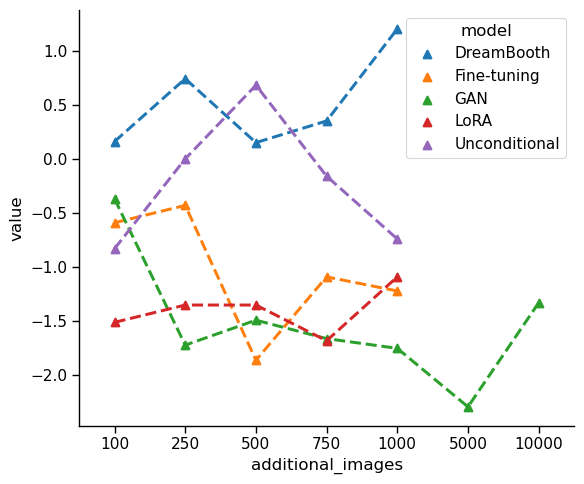

In [213]:
df_plot = df_total_pivot.pivot(columns='additional_images',index='method',values='mean_acc_mean').reset_index().melt(id_vars='method',value_vars=[100,250,500,750,1000,5000,10000])
df_plot['value'] = round(df_plot['value']*100,2)
df_plot.rename(columns={'method':'model'},inplace=True)
df_plot['model'] = df_plot['model'].map(model_name_mapping)
sns.set_context('paper',font_scale=1.25)
sns.catplot(data=df_plot,
            x='additional_images',y='value',hue='model',
            kind='point',palette=None,markers='^',linestyles='--',legend_out=False,aspect=1.2,scale=1)
#plt.xlabel('additional images',fontsize=14)
#plt.ylabel('value',fontsize=14)
plt.savefig('export/clf_metrics/plots/additional_images_acc.pdf')
plt.show()

#### Summary Balanced Accuracy

In [191]:
df_total_pivot_balacc

,method,ResNet50_bal_acc_mean,EB0_bal_acc_mean,EB1_bal_acc_mean,ConvNeXt_tiny_bal_acc_mean,ConvNeXt_small_bal_acc_mean,mean_bal_acc_mean,additional_images
0,dreambooth,-0.0416,0.0202,0.0198,-0.0079,0.0072,-0.00046,100
1,finetuning,-0.0046,-0.0060,-0.0036,-0.0234,0.0421,0.00090,100
2,gan,0.0094,-0.0068,-0.0154,-0.0077,-0.0327,-0.01064,100
3,lora,-0.0750,-0.0333,0.0010,0.0028,-0.0115,-0.02320,100
4,unconditional,-0.0102,-0.0255,-0.0041,-0.0212,0.0395,-0.00430,100
0,dreambooth,0.0052,-0.0014,0.0222,0.0089,0.0003,0.00704,250
1,finetuning,0.0209,-0.0212,-0.0099,-0.0495,0.0265,-0.00664,250
2,gan,-0.0058,-0.0455,-0.0304,-0.0309,-0.0025,-0.02302,250
3,lora,-0.0738,-0.0350,-0.0249,0.0013,0.0293,-0.02062,250
4,unconditional,-0.0186,-0.0332,0.0046,0.0009,0.0503,0.00080,250


Mean per model:

In [192]:
methods = ['dreambooth','finetuning','gan','lora','unconditional']

In [193]:
model_means = np.mean(df_total_pivot_balacc[['ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].values,axis=0)

In [194]:
text = ''

for method in methods:
    text = text + method + ' & '
    mean_list = np.mean(df_total_pivot_balacc.loc[df_total_pivot_balacc['method']==method,['ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].values,axis=0)
    total_mean = np.mean(df_total_pivot_balacc.loc[df_total_pivot_balacc['method']==method,['ResNet50_bal_acc_mean','EB0_bal_acc_mean','EB1_bal_acc_mean','ConvNeXt_tiny_bal_acc_mean','ConvNeXt_small_bal_acc_mean']].values)

    for value in np.append(mean_list,total_mean):
        text = text + str(round(value*100,2)) + ' & '

    text = text[:-2] + '\\\\' +'\n'

text = text + 'mean' + ' & '
for mean in model_means:
    text = text + str(round(mean*100,2)) + ' & '
text = text[:-2] + '\\\\' +'\n'

In [195]:
print(text)

dreambooth & -0.39 & 0.68 & 0.92 & -0.03 & 0.85 & 0.4 \\
finetuning & -0.19 & -3.09 & -1.8 & -2.87 & 1.26 & -1.34 \\
gan & -1.97 & -4.69 & -4.27 & -2.15 & -0.39 & -2.69 \\
lora & -5.47 & -3.29 & -1.75 & -0.8 & 0.66 & -2.13 \\
unconditional & 1.08 & -2.27 & -0.64 & -0.77 & 2.99 & 0.08 \\
mean & -1.43 & -2.69 & -1.71 & -1.39 & 0.96 \\



Mean per additional image bracket:

In [196]:
df_total_pivot_balacc.pivot(columns='additional_images',index='method',values='mean_bal_acc_mean')

additional_images,100,250,500,750,1000,5000,10000
method,,,,,,,
dreambooth,-0.00046,0.00704,0.00354,-0.00188,0.01198,NaN,NaN
finetuning,0.00090,-0.00664,-0.02680,-0.01506,-0.01928,NaN,NaN
gan,-0.01064,-0.02302,-0.02468,-0.02990,-0.02830,-0.04306,-0.0289
lora,-0.02320,-0.02062,-0.01902,-0.02606,-0.01766,NaN,NaN
unconditional,-0.00430,0.00080,0.01520,0.00202,-0.00988,NaN,NaN


In [197]:
means= np.nanmean(df_total_pivot_balacc.pivot(columns='additional_images',index='method',values='mean_bal_acc_mean').values,axis=0)

In [198]:
text = 'mean & '
for value in means:
    text = text + str(round(value*100,2)) + ' & '
text = text[:-2] + '\\\\'


In [199]:
print_plain_values_to_latex(df_total_pivot_balacc.pivot(columns='additional_images',index='method',values='mean_bal_acc_mean'),rounding=True)
print(text)

dreambooth & -0.05 & 0.7 & 0.35 & -0.19 & 1.2 & nan & nan \\
finetuning & 0.09 & -0.66 & -2.68 & -1.51 & -1.93 & nan & nan \\
gan & -1.06 & -2.3 & -2.47 & -2.99 & -2.83 & -4.31 & -2.89 \\
lora & -2.32 & -2.06 & -1.9 & -2.61 & -1.77 & nan & nan \\
unconditional & -0.43 & 0.08 & 1.52 & 0.2 & -0.99 & nan & nan \\

mean & -0.75 & -0.85 & -1.04 & -1.42 & -1.26 & -4.31 & -2.89 \\


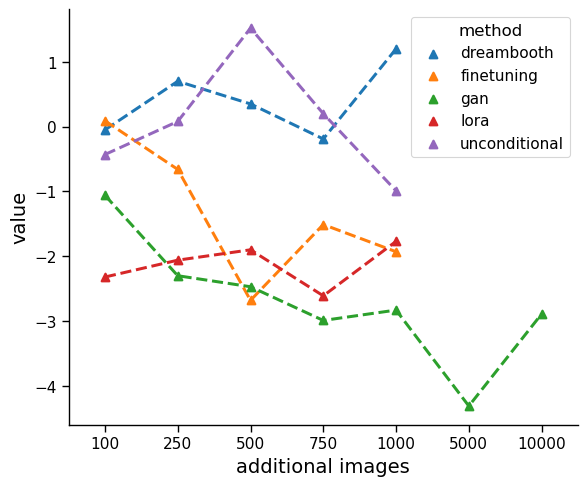

In [201]:
df_plot = df_total_pivot_balacc.pivot(columns='additional_images',index='method',values='mean_bal_acc_mean').reset_index().melt(id_vars='method',value_vars=[100,250,500,750,1000,5000,10000])
df_plot['value'] = round(df_plot['value']*100,2)
sns.catplot(data=df_plot,
            x='additional_images',y='value',hue='method',
            kind='point',palette=None,markers='^',linestyles='--',legend_out=False,aspect=1.2,scale=1)
plt.xlabel('additional images',fontsize=14)
plt.ylabel('value',fontsize=14)
plt.savefig('export/clf_metrics/plots/additional_images_balacc.pdf')
plt.show()

## Precision, Recall, F1

In [202]:
def list_to_latex(lst,two_elements=False,rounding=None):
    string = ''
    if rounding:
        lst = [round(x,rounding) for x in lst]

    if two_elements:
        lst1 = lst[0::2]
        lst2 = lst[1::2]

        for element1,element2 in zip(lst1,lst2):
            string = string + f'{str(element1)[1:]} $\pm$ {str(element2)[1:]} & '

    else:
        for element in lst:
            string = string + str(element) + ' & '

    string = string[:-3]
    return string

In [203]:
metric_mapping = {'Prec' : 'precision',
                  'Rec' : 'recall',
                  'F1' : 'f1'}

df_long = pd.DataFrame()

for images in ['100','250','500','750','1000','5000','10000','baseline']:
    df = pd.read_csv('../KD_Paper/Revision/export/model_metrics_do_balacc.csv') if images=='baseline' else pd.read_csv(f'export/clf_metrics/model_metrics_{images}.csv')
    df.columns = ['model']+[f'{x}_{y}_{z}' for x,y,z in itertools.product([0,1,2,3,4],['Prec','Rec','F1'],['mean','std'])]+['acc_mean','acc_std','bal_acc_mean','bal_acc_std']
    df.drop(index=[0,1],inplace=True)

    for label,label_name in label_mapping.items():
        for metric,metric_name in metric_mapping.items():
            for aggfunc in ['mean','std']:
                df_temp = pd.DataFrame()
                df_temp['value'] = df[f'{label}_{metric}_{aggfunc}']
                df_temp['model'] = df['model']
                df_temp['var'] = metric_name
                df_temp['class'] = label_name
                df_temp['aggfunc'] = aggfunc
                df_temp['images'] = images

                df_long = pd.concat([df_long,df_temp])

df_long.reset_index(inplace=True,drop=True)
df_long.loc[df_long['model'].str.contains('EB1'),'architecture'] = 'EB1'
df_long.loc[df_long['model'].str.contains('EB0'),'architecture'] = 'EB0'
df_long.loc[df_long['model'].str.contains('ConvNeXt_small'),'architecture'] = 'ConvNeXt_small'
df_long.loc[df_long['model'].str.contains('ConvNeXt_tiny'),'architecture'] = 'ConvNeXt_tiny'
df_long.loc[df_long['model'].str.contains('ResNet50'),'architecture'] = 'ResNet50'

df_long.loc[df_long['model'].str.contains('gan'),'method'] = 'gan'
df_long.loc[df_long['model'].str.contains('sd_finetuning'),'method'] = 'finetuning'
df_long.loc[df_long['model'].str.contains('sd_dreambooth'),'method'] = 'dreambooth'
df_long.loc[df_long['model'].str.contains('unconditional'),'method'] = 'unconditional'
df_long.loc[df_long['model'].str.contains('sd_lora_1e5_scale1'),'method'] = 'lora'
df_long.loc[df_long['model'].str.contains('Baseline'),'method'] = 'baseline'
df_long = df_long.drop('model',axis=1)

# swap F and H due to different naming in df between baseline and synthetic
df_long.loc[df_long['method'] != 'baseline','class'] = df_long.loc[df_long['method'] != 'baseline','class'].map({'B' : 'B','C' : 'C', 'H' : 'F', 'F' : 'H', 'V' : 'V'})
            

Beste Image brackets pro Methode für ConvNeXt-S, gemessen an Accuracy:
* dreambooth: +100 oder +1000, sind identisch, aber +1000 deutlich besser über alle Architekturen
* finetuning: +100
* gan: +10000
* lora: +250
* unconditional: +250 

In [204]:
best_method_image_brackets = {'baseline' : 'baseline',
                              'dreambooth' : '1000',
                              'finetuning' : '100',
                              'gan' : '10000',
                              'lora' : '250',
                              'unconditional' : '250'}

In [205]:
metric_names = {'Precision' : 'precision',
                  'Recall' : 'recall',
                  'F1-Score' : 'f1'}
print('model & B & C & F & H & V \\\\ \midrule')
for metric_name,metric in metric_names.items():
    print(f'{metric_name} \\\\')
    values = []
    for (method,image_bracket),stat in itertools.product(best_method_image_brackets.items(),['mean','std']):
        filt_df = df_long[(df_long['architecture'] == 'ConvNeXt_small') & (df_long['var'] == metric) & (df_long['images'] == image_bracket) & (df_long['method'] == method) & (df_long['aggfunc'] == stat)]
        filt_df_pivot = filt_df.pivot_table(columns='class',values='value',aggfunc=max)
        values.append(filt_df_pivot.values.tolist())
        
    
    for i,(method,_) in enumerate(best_method_image_brackets.items()):
        mean_values = values[i*2][0]
        std_values = values[i*2+1][0]
        combined = [x for row in list(zip(mean_values,std_values)) for x in row]
        print(f'{method} & {list_to_latex(combined,two_elements=True)} \\\\')
    print()

model & B & C & F & H & V \\ \midrule
Precision \\
baseline & .326 $\pm$ .0498 & .8292 $\pm$ .0573 & .4946 $\pm$ .0141 & .9641 $\pm$ .0028 & .1329 $\pm$ .1097 \\
dreambooth & .4618 $\pm$ .055 & .7466 $\pm$ .0933 & .5085 $\pm$ .0592 & .9368 $\pm$ .0209 & .1826 $\pm$ .1581 \\
finetuning & .2955 $\pm$ .151 & .7164 $\pm$ .0696 & .6073 $\pm$ .0537 & .9503 $\pm$ .0221 & .5112 $\pm$ .1291 \\
gan & .4569 $\pm$ .0595 & .8144 $\pm$ .1343 & .5506 $\pm$ .0414 & .9348 $\pm$ .0179 & .0848 $\pm$ .1291 \\
lora & .3778 $\pm$ .0697 & .716 $\pm$ .1297 & .5669 $\pm$ .0936 & .9501 $\pm$ .0029 & .3738 $\pm$ .0928 \\
unconditional & .4254 $\pm$ .1318 & .7038 $\pm$ .0405 & .639 $\pm$ .0673 & .9391 $\pm$ .0135 & .4383 $\pm$ .1233 \\

Recall \\
baseline & .3474 $\pm$ .0976 & .7478 $\pm$ .0928 & .5517 $\pm$ .0899 & .9923 $\pm$ .0049 & .1 $\pm$ .0848 \\
dreambooth & .3684 $\pm$ .1104 & .8174 $\pm$ .0174 & .5034 $\pm$ .1536 & .9954 $\pm$ .0038 & .1375 $\pm$ .1275 \\
finetuning & .3474 $\pm$ .2297 & .7478 $\pm$ .08

In [206]:
filt_df_pivot

class,B,C,F,H,V
value,0.0764,0.0906,0.0341,0.0071,0.0876
